In [35]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import yfinance as yf
from scipy import stats
import statsmodels.api as sm 
import seaborn as sns
import dataframe_image as dfi
from tabulate import tabulate


In [4]:
import pandas as pd

file_path = "SHCOMP_prices_mktcap_volum_shares - ELABORATED.xlsx"

sheets = pd.read_excel(file_path, sheet_name=None, decimal=".")

cleaned_sheets = {}

for name, df in sheets.items():
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
        df = df.dropna(subset=["Date"])
        df = df.sort_values(by="Date")
        df = df.set_index("Date")
    cleaned_sheets[name] = df

S_C_I = cleaned_sheets["S_C_I"]
stocks = cleaned_sheets["com_prices"]
stocks_d_mktcap = cleaned_sheets["comp_marketcap"]
stocks_d_volume = cleaned_sheets["comp_volume"]
stocks_d_shares_outstanding= cleaned_sheets["comp_shares outstanding"]
EEM= yf.download('EEM', start='2020-01-01', end='2025-10-10', auto_adjust=True, progress=False)['Close']

components = sheets["Components"].copy()
print(list(components.columns))

stocks_Sector_Industry= components[['Ticker', 'GICS Sector\n', 'GICS Ind Name\n',]]
stocks_Sector_Industry = stocks_Sector_Industry.rename(columns={
    'GICS Sector\n': 'Sector',
    'GICS Ind Name\n': 'Industry'
})
display(stocks_Sector_Industry)



['Ticker', 'Name', 'Weight', 'Shares', 'Price', 'GICS Ind Grp Name\n', 'ISIN\n', 'GICS Ind Name\n', 'GICS Sector\n']


,Ticker,Sector,Industry
0,601288 CH Equity,Financials,Banks
1,601398 CH Equity,Financials,Banks
2,600519 CH Equity,Consumer Staples,Beverages
3,601857 CH Equity,Energy,"Oil, Gas & Consumable Fuels"
4,601988 CH Equity,Financials,Banks
...,...,...,...
2229,900913 CH Equity,Energy,"Oil, Gas & Consumable Fuels"
2230,900921 CH Equity,Materials,Chemicals
2231,900915 CH Equity,Consumer Discretionary,Leisure Products
2232,900922 CH Equity,Consumer Discretionary,"Textiles, Apparel & Luxury Goods"


In [5]:
stocks.columns = stocks.columns.str.strip()
stocks_Sector_Industry['Ticker'] = stocks_Sector_Industry['Ticker'].astype(str).str.strip()

sector_map = stocks_Sector_Industry.set_index('Ticker')['Sector'].to_dict()
industry_map = stocks_Sector_Industry.set_index('Ticker')['Industry'].to_dict()

firm_data = pd.DataFrame(index=stocks.columns)
firm_data['Sector'] = firm_data.index.map(sector_map)
firm_data['Industry'] = firm_data.index.map(industry_map)

missing = firm_data[firm_data['Sector'].isna()].index.tolist()
print(f"Matched tickers: {firm_data['Sector'].notna().sum()} / {len(firm_data)}")
if missing:
    print(f"Missing: {len(missing)}")
    print(missing[:10])

display(firm_data.head(10))


Matched tickers: 999 / 999


,Sector,Industry
601288 CH Equity,Financials,Banks
601398 CH Equity,Financials,Banks
600519 CH Equity,Consumer Staples,Beverages
601857 CH Equity,Energy,"Oil, Gas & Consumable Fuels"
601988 CH Equity,Financials,Banks
601138 CH Equity,Information Technology,"Electronic Equipment, Instruments & Components"
600036 CH Equity,Financials,Banks
601628 CH Equity,Financials,Insurance
601088 CH Equity,Energy,"Oil, Gas & Consumable Fuels"
600900 CH Equity,Utilities,Independent Power and Renewable Electricity Pr...


In [39]:
EVENT_DATE = pd.Timestamp('2024-09-24')

START, END = 250, 20 
EV_PRE, EV_POST    = 1, 3     
t0 = EVENT_DATE

est_start = t0 - pd.Timedelta(days=START)
est_end   = t0 - pd.Timedelta(days=END)
ev_start  = t0 - pd.Timedelta(days=EV_PRE)
ev_end    = t0 + pd.Timedelta(days=EV_POST)

stocks.index = pd.to_datetime(stocks.index)
stocks_ante= stocks.loc[EVENT_DATE - pd.Timedelta(days=START) : EVENT_DATE - pd.Timedelta(days=END)]
stocks_post= stocks.loc[EVENT_DATE: ]
vol_ante= stocks_d_volume.loc[EVENT_DATE - pd.Timedelta(days=START) : EVENT_DATE - pd.Timedelta(days=END)]
vol_post= stocks_d_volume.loc[EVENT_DATE: ]

In [7]:
# PRE-EVENT MEAN
period_start, period_end = est_start, est_end

mcap_slice = stocks_d_mktcap.loc[period_start:period_end].apply(pd.to_numeric, errors='coerce').ffill()
daily_w = mcap_slice.div(mcap_slice.sum(axis=1), axis=0)
w_mean_pre = daily_w.mean(axis=0).dropna()
w_mean_pre = w_mean_pre / w_mean_pre.sum()
w_mean_pre.name = f"w_mean_{period_start.date()}_{period_end.date()}"

display(w_mean_pre.sort_values(ascending=False).head(10))

#POST-EVENT/RALLY MEAN
mcap_slice = stocks_d_mktcap.loc[t0:].apply(pd.to_numeric, errors='coerce').ffill()
daily_w = mcap_slice.div(mcap_slice.sum(axis=1), axis=0)
w_mean_post = daily_w.mean(axis=0).dropna()
w_mean_post = w_mean_post / w_mean_post.sum()
w_mean_post.name = f"w_mean_{period_start.date()}_{period_end.date()}"

display(w_mean_post.sort_values(ascending=False).head(10))

#EVENT-MEAN
period_start, period_end = ev_start, ev_end

mcap_slice = stocks_d_mktcap.loc[period_start:period_end].apply(pd.to_numeric, errors='coerce').ffill()
daily_w = mcap_slice.div(mcap_slice.sum(axis=1), axis=0)
w_mean_ev = daily_w.mean(axis=0).dropna()
w_mean_ev = w_mean_ev / w_mean_ev.sum()
w_mean_ev.name = f"w_mean_{period_start.date()}_{period_end.date()}"

# opzionale: occhiata ai top pesi medi
display(w_mean_ev.sort_values(ascending=False).head(10))


600519 CH Equity    0.041829
601398 CH Equity    0.038238
601857 CH Equity    0.034579
601288 CH Equity    0.030948
600941 CH Equity    0.030002
601939 CH Equity    0.025538
601988 CH Equity    0.025449
600938 CH Equity    0.018086
600036 CH Equity    0.017037
601088 CH Equity    0.015965
Name: w_mean_2024-01-18_2024-09-04, dtype: float64

601398 CH Equity    0.041043
601288 CH Equity    0.034028
600519 CH Equity    0.033748
600941 CH Equity    0.029214
601939 CH Equity    0.029148
601988 CH Equity    0.026818
601857 CH Equity    0.026415
600036 CH Equity    0.018653
601628 CH Equity    0.017079
601318 CH Equity    0.016331
Name: w_mean_2024-01-18_2024-09-04, dtype: float64

601398 CH Equity    0.041454
600519 CH Equity    0.037657
601288 CH Equity    0.034065
601857 CH Equity    0.030591
600941 CH Equity    0.030276
601939 CH Equity    0.028605
601988 CH Equity    0.027307
601628 CH Equity    0.018377
600938 CH Equity    0.017799
600036 CH Equity    0.017674
Name: w_mean_2024-09-23_2024-09-27, dtype: float64

# **HP1**

# *Shanghai Composite Index Abnormal returns*


[SCI] Event window [-1,+3] — full table:


,r_S_C_I,r_hat,AR,t_AR,CAR,t_CAR
Date,,,,,,
2024-09-23,0.003633,0.002537,0.001096,0.129786,0.001096,NaN
2024-09-24,0.043632,0.011909,0.031722,3.757376,0.032818,NaN
2024-09-25,0.011266,-0.004143,0.015409,1.825159,0.048227,NaN
2024-09-26,0.038741,0.012809,0.025932,3.071524,0.074159,NaN
2024-09-27,0.028413,-0.000987,0.029400,3.482289,0.103558,6.068174



t-CAR[-1,+1] = 3.947 ***
t-CAR[-1,+3] = 6.068 ***


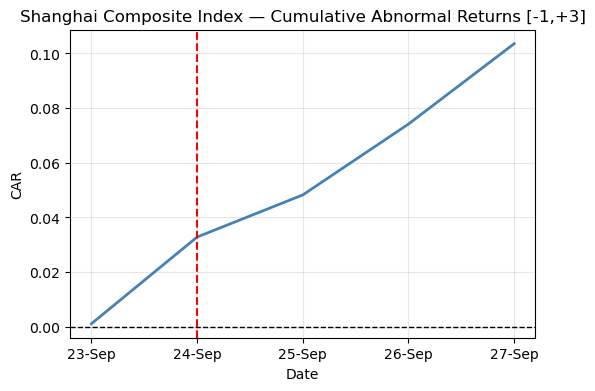

In [8]:
r_S_C_I = np.log(S_C_I / S_C_I.shift(1)).dropna()
r_EEM   = np.log(EEM / EEM.shift(1)).dropna()

ret_df = pd.concat([r_S_C_I, r_EEM], axis=1).dropna()
ret_df.columns = ['r_S_C_I', 'r_EEM']

est_df = ret_df.loc[est_start:est_end]
ev_df  = ret_df.loc[ev_start:ev_end]

X_est = sm.add_constant(est_df['r_EEM'])
y_est = est_df['r_S_C_I']
mm = sm.OLS(y_est, X_est).fit()

alpha = mm.params['const']
beta  = mm.params['r_EEM']
sigma_eps = mm.resid.std(ddof=int(mm.df_model)+1)

X_ev = sm.add_constant(ev_df['r_EEM'])
r_hat = mm.predict(X_ev)
AR_idx = ev_df['r_S_C_I'] - r_hat
CAR_idx = AR_idx.cumsum()
t_AR = AR_idx / sigma_eps

def tstat_car(AR_series, start, end, sigma):
    win = AR_series.loc[start:end]
    n = len(win)
    if n < 1 or sigma is None or sigma <= 0:
        return np.nan
    return win.sum() / (sigma * np.sqrt(n))

t_CAR_01 = tstat_car(AR_idx, t0, t0 + pd.Timedelta(days=1), sigma_eps)
t_CAR_03 = tstat_car(AR_idx, t0, t0 + pd.Timedelta(days=3), sigma_eps)

out_idx = pd.DataFrame({
    'r_S_C_I': ev_df['r_S_C_I'],
    'r_hat': r_hat,
    'AR': AR_idx,
    't_AR': t_AR,
    'CAR': CAR_idx
})

out_idx['t_CAR'] = np.nan
out_idx.loc[out_idx.index.max(), 't_CAR'] = t_CAR_03

def stars(t):
    if pd.isna(t): return ''
    at = abs(t)
    return '***' if at >= 2.58 else '**' if at >= 1.96 else '*' if at >= 1.65 else ''

print("\n[SCI] Event window [-1,+3] — full table:")
display(out_idx)

print(f"\nt-CAR[-1,+1] = {t_CAR_01:.3f} {stars(t_CAR_01)}")
print(f"t-CAR[-1,+3] = {t_CAR_03:.3f} {stars(t_CAR_03)}")

plt.figure(figsize=(6,4))
plt.plot(CAR_idx, color='steelblue', linewidth=2)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Shanghai Composite Index — Cumulative Abnormal Returns [-1,+3]")
plt.xlabel("Date")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.axvline(t0, color='r', ls='--', label='Event day(24/09/2024)')
plt.ylabel("CAR")
plt.grid(alpha=0.3)
plt.show()


# *Sectors Abnormal Returns OVER SHANGHAI*


=== Settorial CAR [-1,+3] (benchmark: SCI) ===


,"CAR[-1,+3]","t-CAR[-1,+3]",sig
Consumer Staples,0.141908,6.158710,***
Financials,0.048553,2.770588,***
Utilities,0.010979,0.514033,
Real Estate,-0.002808,-0.091592,
Communication Services,-0.013956,-0.591512,
Energy,-0.015547,-0.452849,
Health Care,-0.015919,-0.629242,
Industrials,-0.027347,-2.776967,***
Materials,-0.027508,-1.644415,
Consumer Discretionary,-0.031001,-1.668461,*


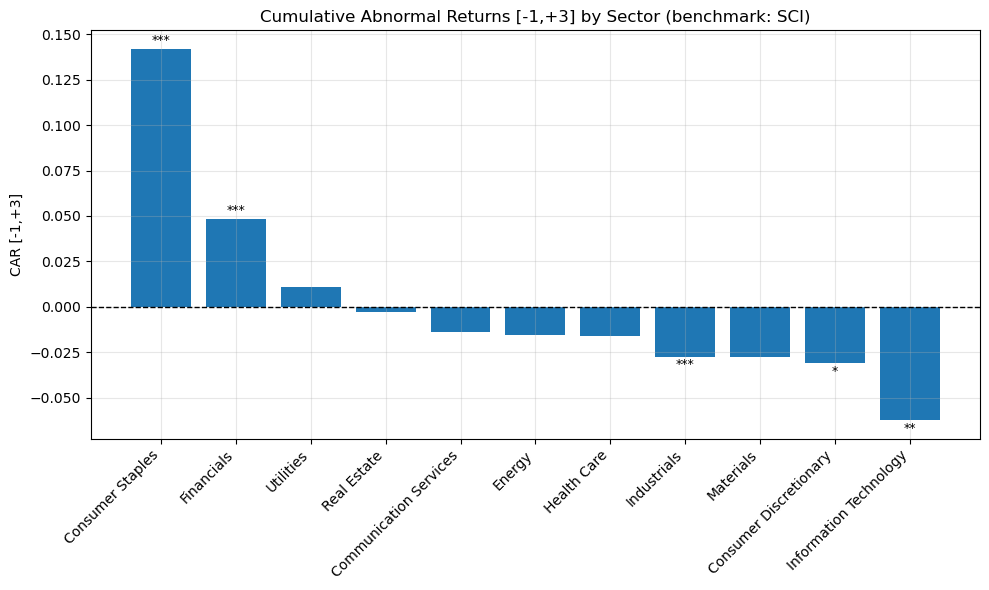

In [9]:
r_stocks = np.log(stocks / stocks.shift(1)).replace([np.inf, -np.inf], np.nan)
r_S_C_I  = np.log(S_C_I / S_C_I.shift(1)).dropna()

mcap_t0 = stocks_d_mktcap.loc[:EVENT_DATE].ffill().iloc[-1]
mcap_t0 = pd.to_numeric(mcap_t0, errors='coerce')

CAR_sector = pd.DataFrame(columns=['CAR[-1,+3]', 't-CAR[-1,+3]'])
sectors = firm_data['Sector'].dropna().unique()

for sec in sectors:
    tickers = firm_data[firm_data['Sector'] == sec].index.intersection(r_stocks.columns)
    if len(tickers) < 5:
        continue

    w = mcap_t0[tickers].astype(float).dropna()
    if len(w) < 5:
        continue

    X = r_stocks[w.index]                                       
    W = pd.DataFrame(1.0, index=X.index, columns=X.columns).mul(w, axis=1)
    W = W.where(~X.isna())                                     
    num = (X * W).sum(axis=1)                                   
    den = W.sum(axis=1)                                         
    r_sector = (num / den).fillna(0)

    ret_df = pd.concat([r_sector, r_S_C_I], axis=1).dropna()
    ret_df.columns = ['r_sector', 'r_S_C_I']

    est_df = ret_df.loc[est_start:est_end]
    ev_df  = ret_df.loc[ev_start:ev_end]
    if len(est_df) < 30 or len(ev_df) < 2:
        continue

    X_est = sm.add_constant(est_df['r_S_C_I'])
    y_est = est_df['r_sector']
    mm = sm.OLS(y_est, X_est).fit()
    sigma_eps = mm.resid.std(ddof=int(mm.df_model)+1)

    X_ev = sm.add_constant(ev_df['r_S_C_I'])
    r_hat = mm.predict(X_ev)
    AR = ev_df['r_sector'] - r_hat
    CAR = AR.cumsum()

    n = len(AR)
    if sigma_eps > 0 and n > 0:
        t_CAR = CAR.iloc[-1] / (sigma_eps * np.sqrt(n))
    else:
        t_CAR = np.nan

    CAR_sector.loc[sec] = [CAR.iloc[-1], t_CAR]

def stars(t):
    if pd.isna(t): return ''
    a = abs(t)
    return '***' if a >= 2.58 else '**' if a >= 1.96 else '*' if a >= 1.65 else ''

CAR_sector['sig'] = CAR_sector['t-CAR[-1,+3]'].apply(stars)
CAR_sector = CAR_sector.sort_values('CAR[-1,+3]', ascending=False)

print("\n=== Settorial CAR [-1,+3] (benchmark: SCI) ===")
display(CAR_sector)

plt.figure(figsize=(10,6))
plt.bar(CAR_sector.index, CAR_sector['CAR[-1,+3]'])
for i, (sec, row) in enumerate(CAR_sector.iterrows()):
    y = row['CAR[-1,+3]']
    label = row['sig']
    if label:
        plt.text(i, y + np.sign(y)*0.001, label, ha='center', va='bottom' if y>=0 else 'top', fontsize=9)
plt.axhline(0, linestyle='--', linewidth=1, color='black')
plt.title("Cumulative Abnormal Returns [-1,+3] by Sector (benchmark: SCI)")
plt.ylabel("CAR [-1,+3]")
plt.xticks(rotation=45, ha='right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


# **HP2**

# **SINCHRONICITY: SAMPLE REGRESSION ON S_C_I**

# PRE EVENT

In [13]:

def REG_pre(stocks_ante, T, robust=False, min_obs=30):
    rows = []
    for tkr in stocks_ante.columns:
        s = stocks_ante[tkr].dropna()
        r_peers = np.log(s) - np.log(s.shift(T))         
        y = r_peers
        x = np.log(S_C_I) - np.log(S_C_I.shift(T))                       
        df = pd.concat([x, y], axis=1, join='inner').dropna()
        df.columns = ['x','y']
        if len(df) < min_obs:
            continue

        X = sm.add_constant(df['x'])
        if robust:
            reg = sm.OLS(df['y'], X).fit(cov_type='HC3')
        else:
            reg = sm.OLS(df['y'], X).fit()

        beta = reg.params['x']
        tval = reg.tvalues['x']
        pval = reg.pvalues['x']
        r2   = reg.rsquared
        sig  = '***' if pval < 0.01 else '**' if pval < 0.05 else '*' if pval < 0.10 else ''

        rows.append({
            'Ticker': tkr,
            'Beta': float(beta),
            't': float(tval),
            'p_value': float(pval),
            'Sign.': sig,
            'R2': float(r2),
            'N': int(reg.nobs)
        })

    out = pd.DataFrame(rows).set_index('Ticker').sort_index()
    return out
REG_pre(stocks_ante, 1, robust=True, min_obs=30)

results_REG_pre = REG_pre(stocks_ante, 1, robust=True, min_obs=30)
sig_REG_pre = results_REG_pre[results_REG_pre['Sign.'] != '']
print("Average R²(ALL):", results_REG_pre['R2'].mean())
print("Average Beta(ALL):", results_REG_pre['Beta'].mean())
print('Average R² (significant):', sig_REG_pre['R2'].mean())
print('Average Beta (significant):', sig_REG_pre['Beta'].mean())
print(f"N. of significant stocks: {len(sig_REG_pre)} / {len(results_REG_pre)}")


tbl = results_REG_pre.copy()
w = w_mean_pre.reindex(tbl.index).fillna(0)

sig_tbl = tbl[tbl['Sign.'] != '']
w_sig = w.reindex(sig_tbl.index).fillna(0)

print(f"Weighted Average R² (ALL):            {np.average(tbl['R2'],   weights=w):.6f}")
print(f"Weighted Average Beta (ALL):          {np.average(tbl['Beta'], weights=w):.6f}")
print(f"Weighted Average R² (significant):    {np.average(sig_tbl['R2'],   weights=w_sig) if len(sig_tbl) else np.nan:.6f}")
print(f"Weighted Average Beta (significant):  {np.average(sig_tbl['Beta'], weights=w_sig) if len(sig_tbl) else np.nan:.6f}")
print(f"Weighted share of significant:        {w_sig.sum()/w.sum():.2%}")


Average R²(ALL): 0.29704181945646463
Average Beta(ALL): 1.5144966427601212
Average R² (significant): 0.30056591277956657
Average Beta (significant): 1.5316050210211078
N. of significant stocks: 986 / 998
Weighted Average R² (ALL):            0.181896
Weighted Average Beta (ALL):          0.872660
Weighted Average R² (significant):    0.227409
Weighted Average Beta (significant):  1.077311
Weighted share of significant:        79.49%


# POST EVENT

In [23]:

def REG_post(stocks_post, T, robust=False, min_obs=30):
    rows = []
    for tkr in stocks_post.columns:
        s = stocks_post[tkr].dropna()
        r_peers = np.log(s) - np.log(s.shift(T))         
        y = r_peers
        x = np.log(S_C_I) - np.log(S_C_I.shift(T))                       
        df = pd.concat([x, y], axis=1, join='inner').dropna()
        df.columns = ['x','y']
        if len(df) < min_obs:
            continue

        X = sm.add_constant(df['x'])
        if robust:
            reg = sm.OLS(df['y'], X).fit(cov_type='HC3')
        else:
            reg = sm.OLS(df['y'], X).fit()

        beta = reg.params['x']
        tval = reg.tvalues['x']
        pval = reg.pvalues['x']
        r2   = reg.rsquared
        sig  = '***' if pval < 0.01 else '**' if pval < 0.05 else '*' if pval < 0.10 else ''

        rows.append({
            'Ticker': tkr,
            'Beta': float(beta),
            't': float(tval),
            'p_value': float(pval),
            'Sign.': sig,
            'R2': float(r2),
            'N': int(reg.nobs)
        })

    out = pd.DataFrame(rows).set_index('Ticker').sort_index()
    return out
REG_post(stocks_post, 1, robust=True, min_obs=30)

results_REG_post = REG_post(stocks_post, 1, robust=True, min_obs=30)
sig_REG_post = results_REG_post[results_REG_post['Sign.'] != '']
print("Average R²(All):", results_REG_post['R2'].mean())
print("Average Beta(ALL):", results_REG_post['Beta'].mean())
print('Average R² (significant):', sig_REG_post['R2'].mean())
print('Average Beta (significant):', sig_REG_post['Beta'].mean())
print(f"N. of significant stocks: {len(sig_REG_post)} / {len(results_REG_post)}")


tbl = results_REG_post.copy()
w = w_mean_post.reindex(tbl.index).fillna(0)

sig_tbl = tbl[tbl['Sign.'] != '']
w_sig = w.reindex(sig_tbl.index).fillna(0)

print(f"Weighted Average R² (ALL):            {np.average(tbl['R2'],   weights=w):.6f}")
print(f"Weighted Average Beta (ALL):          {np.average(tbl['Beta'], weights=w):.6f}")
print(f"Weighted Average R² (significant):    {np.average(sig_tbl['R2'],   weights=w_sig) if len(sig_tbl) else np.nan:.6f}")
print(f"Weighted Average Beta (significant):  {np.average(sig_tbl['Beta'], weights=w_sig) if len(sig_tbl) else np.nan:.6f}")
print(f"Weighted share of significant:        {w_sig.sum()/w.sum():.2%}")


Average R²(All): 0.34071132632479784
Average Beta(ALL): 1.2260655299687486
Average R² (significant): 0.34155325322241037
Average Beta (significant): 1.2286336028559852
N. of significant stocks: 996 / 999
Weighted Average R² (ALL):            0.316077
Weighted Average Beta (ALL):          0.925339
Weighted Average R² (significant):    0.316522
Weighted Average Beta (significant):  0.926393
Weighted share of significant:        99.82%


In [30]:

sector_map = firm_data['Sector']      
r2_pre  = results_REG_pre['R2']
r2_post = results_REG_post['R2']
w_pre   = w_mean_pre
w_post  = w_mean_post

def _align_series(*series_list):
    """Intersect indices across all input series to ensure perfect alignment."""
    common_idx = None
    for s in series_list:
        if s is None: 
            continue
        common_idx = s.index if common_idx is None else common_idx.intersection(s.index)
    return [ (s.loc[common_idx] if s is not None else None) for s in series_list ]

def _sector_aggregate_r2(r2: pd.Series, w: pd.Series, sector_map: pd.Series) -> pd.Series:
    """
    Compute sector-level synchronicity as a value-weighted R²:
    within each sector, normalize weights to sum to 1, then sum w_norm * R².
    """
    r2, w, sector_map = _align_series(r2, w, sector_map)

    df = pd.DataFrame({
        "sector": sector_map,
        "r2": r2,
        "w": w
    }).dropna(subset=["sector", "r2", "w"])

    def _agg_sector(g):
        wsum = g["w"].sum()
        if wsum <= 0 or np.isclose(wsum, 0.0):
            return (g["r2"]).mean()
        w_norm = g["w"] / wsum
        return (w_norm * g["r2"]).sum()

    sector_r2 = df.groupby("sector", sort=True).apply(_agg_sector)
    sector_r2.name = "sector_r2"
    return sector_r2

sector_r2_pre  = _sector_aggregate_r2(r2_pre,  w_pre,  sector_map)
sector_r2_post = _sector_aggregate_r2(r2_post, w_post, sector_map)

sector_sync = pd.concat(
    [sector_r2_pre.rename("Sector R² (Pre)"),
     sector_r2_post.rename("Sector R² (Post)")],
    axis=1
)

sector_sync["Δ (Post – Pre)"] = sector_sync["Sector R² (Post)"] - sector_sync["Sector R² (Pre)"]

sector_sync = sector_sync.sort_values(by="Sector R² (Post)", ascending=False)

display_cols = ["Sector R² (Pre)", "Sector R² (Post)", "Δ (Post – Pre)"]
sector_sync_formatted = sector_sync.copy()
sector_sync_formatted[display_cols] = sector_sync_formatted[display_cols].applymap(
    lambda x: f"{x:.3f}" if pd.notnull(x) else ""
)

print("== Sector Synchronicity (Value-Weighted R²) — Pre vs Post ==")
display(sector_sync_formatted)

== Sector Synchronicity (Value-Weighted R²) — Pre vs Post ==


C:\Users\andre\AppData\Local\Temp\ipykernel_23684\3994387177.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sector_r2 = df.groupby("sector", sort=True).apply(_agg_sector)
C:\Users\andre\AppData\Local\Temp\ipykernel_23684\3994387177.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sector_r2 = df.groupby("sector", sort=True).apply(_agg_sector)
C:\Users\andre\AppData\Local\Temp\ipykernel_23684\399438

,Sector R² (Pre),Sector R² (Post),Δ (Post – Pre)
sector,,,
Consumer Staples,0.174,0.446,0.272
Real Estate,0.299,0.378,0.078
Industrials,0.277,0.365,0.087
Health Care,0.217,0.343,0.126
Consumer Discretionary,0.227,0.321,0.094
Materials,0.278,0.320,0.042
Information Technology,0.283,0.311,0.029
Energy,0.102,0.301,0.198
Financials,0.117,0.296,0.178


# *AMIHUD ratio

C:\Users\andre\AppData\Local\Temp\ipykernel_23684\2845667431.py:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('sector', group_keys=False, sort=True).apply(_agg)
C:\Users\andre\AppData\Local\Temp\ipykernel_23684\2845667431.py:62: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('sector', group_keys=False, sort=True).apply(_agg)


,Amihud (Pre),Amihud (Post),Δ Amihud,N
sector,,,,
Communication Services,216.988141,130.689102,-86.299039,31
Consumer Discretionary,561.094370,306.846448,-254.247922,72
Consumer Staples,262.571629,164.816803,-97.754826,49
Energy,185.864652,134.527062,-51.337591,35
Financials,128.550983,78.450121,-50.100862,79
Health Care,780.621143,415.936457,-364.684686,93
Industrials,622.082946,339.336920,-282.746026,232
Information Technology,730.307544,295.093455,-435.214089,200
Materials,684.951029,358.589008,-326.362021,135


C:\Users\andre\AppData\Local\Temp\ipykernel_23684\2845667431.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, y='sector', x='Δ Amihud', order=order, palette='Blues')


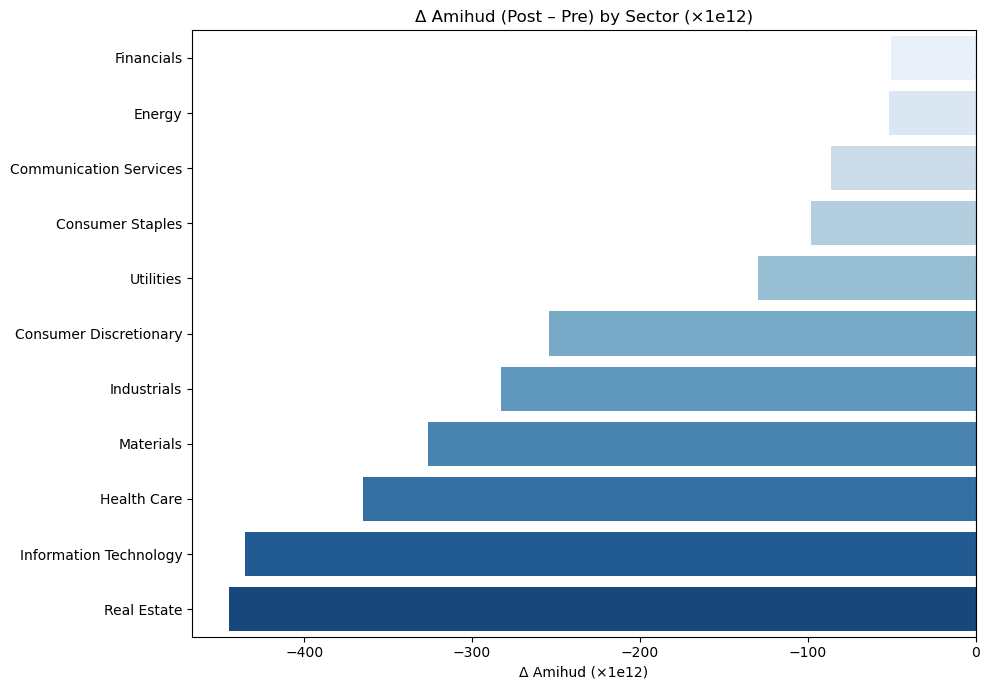

In [45]:
import numpy as np, pandas as pd
import seaborn as sns, matplotlib.pyplot as plt
import dataframe_image as dfi

sector_map = firm_data['sector'] if 'sector' in firm_data.columns else firm_data['Sector']

# ---- volumi in pezzi (con fallback da un unico DF) ----
vol_ante  = globals().get('vol_ante',  None)
vol_post  = globals().get('vol_post',  None)
vol_all   = globals().get('comp_volume', globals().get('volumes', None))

def _align_both(px: pd.DataFrame, vol: pd.DataFrame):
    idx = px.index.intersection(vol.index)
    cols = px.columns.intersection(vol.columns)
    return px.loc[idx, cols].sort_index(), vol.loc[idx, cols].sort_index()

if vol_ante is None or vol_post is None:
    assert vol_all is not None, "Serve un DataFrame di volumi (es. comp_volume)."
    # riallineo ai due periodi usando gli indici di prezzo
    vol_ante, _ = _align_both(stocks_ante, vol_all)
    vol_post, _ = _align_both(stocks_post, vol_all)

def _amihud_per_stock_shares(px: pd.DataFrame, vol_shares: pd.DataFrame) -> pd.Series:
    px, vol_shares = _align_both(px, vol_shares)
    ret = px.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan)
    dollar_vol = (px * vol_shares).replace(0, np.nan).replace([np.inf, -np.inf], np.nan)
    am = (ret.abs() / dollar_vol).replace([np.inf, -np.inf], np.nan)
    return am.mean(skipna=True)

amihud_pre_stock  = _amihud_per_stock_shares(stocks_ante, vol_ante).rename('Amihud (Pre)')
amihud_post_stock = _amihud_per_stock_shares(stocks_post, vol_post).rename('Amihud (Post)')
amihud_stock = pd.concat([amihud_pre_stock, amihud_post_stock], axis=1)

def _align_series(*slist):
    idx = None; out = []
    for s in slist:
        s = s[~s.index.duplicated(keep='first')]
        idx = s.index if idx is None else idx.intersection(s.index)
        out.append(s)
    return [s.loc[idx] for s in out]

def _sector_agg(amihud_tbl: pd.DataFrame, w: pd.Series, sector_map: pd.Series) -> pd.DataFrame:
    pre, post, w, sec = _align_series(amihud_tbl['Amihud (Pre)'], amihud_tbl['Amihud (Post)'], w, sector_map)
    df = pd.DataFrame({'sector': sec, 'pre': pre, 'post': post, 'w': w}).dropna()
    def _agg(g):
        ws = g['w'].sum()
        if ws <= 0 or np.isclose(ws, 0.0):
            pre_vw  = g['pre'].mean()
            post_vw = g['post'].mean()
        else:
            pre_vw  = np.average(g['pre'],  weights=g['w'])
            post_vw = np.average(g['post'], weights=g['w'])
        return pd.Series({'Amihud (Pre)': pre_vw, 'Amihud (Post)': post_vw, 'N': len(g)})
    return df.groupby('sector', group_keys=False, sort=True).apply(_agg)

amihud_sector_pre  = _sector_agg(amihud_stock, w_mean_pre,  sector_map)
amihud_sector_post = _sector_agg(amihud_stock, w_mean_post, sector_map)

amihud_sector = amihud_sector_pre[['Amihud (Pre)','N']].join(
    amihud_sector_post[['Amihud (Post)']], how='outer'
)
amihud_sector['Δ Amihud'] = amihud_sector['Amihud (Post)'] - amihud_sector['Amihud (Pre)']

def _auto_scale(x: pd.Series):
    med = x.replace(0, np.nan).abs().median()
    if pd.isna(med):
        return 1, ''
    if med < 1e-9:  return 1e12, ' (×1e12)'
    if med < 1e-6:  return 1e9,  ' (×1e9)'
    if med < 1e-3:  return 1e6,  ' (×1e6)'
    if med < 1e-1:  return 1e3,  ' (×1e3)'
    return 1, ''

scale, tag = _auto_scale(amihud_sector[['Amihud (Pre)','Amihud (Post)']].stack())
amihud_sector_scaled = amihud_sector.copy()
amihud_sector_scaled[['Amihud (Pre)','Amihud (Post)','Δ Amihud']] *= scale

display_cols = ['Amihud (Pre)','Amihud (Post)','Δ Amihud','N']
styled = (amihud_sector_scaled[display_cols]
          .style.format({'Amihud (Pre)':'{:.6f}','Amihud (Post)':'{:.6f}','Δ Amihud':'{:.6f}','N':'{:,.0f}'})
          .background_gradient(subset=['Δ Amihud'], cmap='Blues_r')
          .set_caption(f'Sector Amihud Illiquidity — Pre vs Post{tag}')
         )

display(styled)

amihud_sector_scaled.to_excel('HPx_amihud_sector_table.xlsx')

plot_df = amihud_sector_scaled.reset_index().rename(columns={'index':'sector'})
order = plot_df.sort_values('Δ Amihud', ascending=False)['sector']
plt.figure(figsize=(10,7))
sns.barplot(data=plot_df, y='sector', x='Δ Amihud', order=order, palette='Blues')
plt.axvline(0, color='black', ls='--', lw=0.8)
plt.title(f'Δ Amihud (Post – Pre) by Sector{tag}')
plt.xlabel(f'Δ Amihud{tag}')
plt.ylabel('')
plt.tight_layout()
plt.savefig('HPx_amihud_delta_barplot.png', bbox_inches='tight', dpi=300)
plt.show()


In [43]:
# Merge tra Amihud e R² per titolo
cross_df = pd.concat([
    amihud_stock,
    results_REG_pre['R2'].rename('R2 (Pre)'),
    results_REG_post['R2'].rename('R2 (Post)')
], axis=1).dropna()

# Crea le variazioni
cross_df['ΔR2'] = cross_df['R2 (Post)'] - cross_df['R2 (Pre)']
cross_df['ΔAmihud'] = cross_df['Amihud (Post)'] - cross_df['Amihud (Pre)']
cross_df


,Amihud (Pre),Amihud (Post),R2 (Pre),R2 (Post),ΔR2,ΔAmihud
601288 CH Equity,3.790299e-11,2.534222e-11,0.000517,0.077183,0.076666,-1.256078e-11
601398 CH Equity,3.351701e-11,2.214858e-11,0.000007,0.100525,0.100518,-1.136843e-11
600519 CH Equity,1.268989e-11,1.137622e-11,0.147141,0.515475,0.368334,-1.313675e-12
601857 CH Equity,5.536419e-11,4.872213e-11,0.110293,0.346423,0.236130,-6.642056e-12
601988 CH Equity,6.802854e-11,4.430561e-11,0.000190,0.145691,0.145501,-2.372293e-11
...,...,...,...,...,...,...
688262 CH Equity,1.746299e-09,6.355053e-10,0.318675,0.392832,0.074157,-1.110794e-09
688523 CH Equity,4.287804e-09,2.222755e-09,0.267021,0.539738,0.272716,-2.065049e-09
688138 CH Equity,3.268985e-09,1.411477e-09,0.441579,0.427713,-0.013865,-1.857508e-09
688276 CH Equity,1.329258e-09,1.394039e-09,0.304579,0.591791,0.287212,6.478141e-11


In [44]:
import statsmodels.api as sm

X = sm.add_constant(cross_df['ΔAmihud'])
model = sm.OLS(cross_df['ΔR2'], X).fit(cov_type='HC3')
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    ΔR2   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     25.10
Date:                Sun, 19 Oct 2025   Prob (F-statistic):           6.45e-07
Time:                        22:46:45   Log-Likelihood:                 508.02
No. Observations:                 998   AIC:                            -1012.
Df Residuals:                     996   BIC:                            -1002.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0691      0.007     10.585      0.0

# **AUTOREGRESSION**

# *AUTOREGRESSION PRE EVENT*

In [22]:

def AR_pre(stocks_ante, T, n, robust=False, min_obs=30):
    rows = []
    for tkr in stocks_ante.columns:
        s = stocks_ante[tkr].dropna()
        r = np.log(s) - np.log(s.shift(T))         
        y = r
        x = r.shift(T * n)                          
        df = pd.DataFrame({'y': y, 'x': x}).dropna()
        if len(df) < min_obs:
            continue

        X = sm.add_constant(df['x'])
        if robust:
            res = sm.OLS(df['y'], X).fit(cov_type='HC3')
        else:
            res = sm.OLS(df['y'], X).fit()

        beta = res.params['x']
        tval = res.tvalues['x']
        pval = res.pvalues['x']
        r2   = res.rsquared
        sig  = '***' if pval < 0.01 else '**' if pval < 0.05 else '*' if pval < 0.10 else ''

        rows.append({
            'Ticker': tkr,
            'Beta': float(beta),
            't': float(tval),
            'p_value': float(pval),
            'Sign.': sig,
            'R2': float(r2),
            'N': int(res.nobs)
        })

    out = pd.DataFrame(rows).set_index('Ticker').sort_index()
    return out
AR_pre(stocks_ante, 1, 1, robust=True, min_obs=30)

result_AR_pre = AR_pre(stocks_ante, T=5, n=1, robust=True, min_obs=30)
sig_pre = result_AR_pre[result_AR_pre['Sign.'] != '']
print("Average R²(All):", result_AR_pre['R2'].mean())
print("Average Beta(ALL):", result_AR_pre['Beta'].mean())
print('Average R² (significant):', sig_pre['R2'].mean())
print('Average Beta (significant):', sig_pre['Beta'].mean())
print(f"N. of significant stocks: {len(sig_pre)} / {len(result_AR_pre)}")


tbl = result_AR_pre.copy()
w = w_mean_pre.reindex(tbl.index).fillna(0)

sig_tbl = tbl[tbl['Sign.'] != '']
w_sig = w.reindex(sig_tbl.index).fillna(0)

print(f"Weighted Average R² (All):           {np.average(tbl['R2'],   weights=w):.6f}")
print(f"Weighted Average Beta (All):         {np.average(tbl['Beta'], weights=w):.6f}")
print(f"Weighted Average R² (significant):   {np.average(sig_tbl['R2'],   weights=w_sig) if len(sig_tbl) else np.nan:.6f}")
print(f"Weighted Average Beta (significant): {np.average(sig_tbl['Beta'], weights=w_sig) if len(sig_tbl) else np.nan:.6f}")
print(f"Weighted share of significant:       {w_sig.sum()/w.sum():.2%}")


Average R²(All): 0.03910692976167142
Average Beta(ALL): -0.12906951369998293
Average R² (significant): 0.06821073277059003
Average Beta (significant): -0.2091296992332438
N. of significant stocks: 516 / 998
Weighted Average R² (All):           0.029424
Weighted Average Beta (All):         -0.119469
Weighted Average R² (significant):   0.054398
Weighted Average Beta (significant): -0.200251
Weighted share of significant:       48.10%


# *AUTOREGRESSION POST EVENT*

In [27]:

def AR_post(stocks_post, T, n, robust=False, min_obs=30):
    rows = []
    for tkr in stocks_post.columns:
        s = stocks_post[tkr].dropna()
        r = np.log(s) - np.log(s.shift(T))         
        y = r
        x = r.shift(T * n)                          
        df = pd.DataFrame({'y': y, 'x': x}).dropna()
        if len(df) < min_obs:
            continue

        X = sm.add_constant(df['x'])
        if robust:
            res = sm.OLS(df['y'], X).fit(cov_type='HC3')
        else:
            res = sm.OLS(df['y'], X).fit()

        beta = res.params['x']
        tval = res.tvalues['x']
        pval = res.pvalues['x']
        r2   = res.rsquared
        sig  = '***' if pval < 0.01 else '**' if pval < 0.05 else '*' if pval < 0.10 else ''

        rows.append({
            'Ticker': tkr,
            'Beta': float(beta),
            't': float(tval),
            'p_value': float(pval),
            'Sign.': sig,
            'R2': float(r2),
            'N': int(res.nobs)
        })

    out = pd.DataFrame(rows).set_index('Ticker').sort_index()
    return out
AR_post(stocks_post, 1, 1, robust=True, min_obs=30)

result_AR_post = AR_post(stocks_post, T=5, n=1, robust=True, min_obs=30)
sig_post = result_AR_post[result_AR_post['Sign.'] != '']
print("Average R²(All):", result_AR_post['R2'].mean())
print("Average Beta(ALL):", result_AR_post['Beta'].mean())
print('Average R² (significant):', sig_post['R2'].mean())
print('Average Beta (significant):', sig_post['Beta'].mean())
print(f"N. of significant stocks: {len(sig_post)} / {len(result_AR_post)}")


tbl = result_AR_post.copy()
w = w_mean_post.reindex(tbl.index).fillna(0)

sig_tbl = tbl[tbl['Sign.'] != '']
w_sig = w.reindex(sig_tbl.index).fillna(0)

print(f"Weighted Average R² (All):           {np.average(tbl['R2'],   weights=w):.6f}")
print(f"Weighted Average Beta (All):         {np.average(tbl['Beta'], weights=w):.6f}")
print(f"Weighted Average R² (significant):   {np.average(sig_tbl['R2'],   weights=w_sig) if len(sig_tbl) else np.nan:.6f}")
print(f"Weighted Average Beta (significant): {np.average(sig_tbl['Beta'], weights=w_sig) if len(sig_tbl) else np.nan:.6f}")
print(f"Weighted share of significant:       {w_sig.sum()/w.sum():.2%}")


Average R²(All): 0.01994111090471623
Average Beta(ALL): -0.08192921867247512
Average R² (significant): 0.03906620837796345
Average Beta (significant): -0.14273266360025105
N. of significant stocks: 426 / 999
Weighted Average R² (All):           0.018276
Weighted Average Beta (All):         -0.090108
Weighted Average R² (significant):   0.034175
Weighted Average Beta (significant): -0.154498
Weighted share of significant:       44.10%


In [33]:
ALPHA = 0.05

sector_map = firm_data['sector'] if 'sector' in firm_data.columns else firm_data['Sector']
r2_pre_AR   = result_AR_pre['R2']
r2_post_AR  = result_AR_post['R2']
beta_pre    = result_AR_pre['Beta']
beta_post   = result_AR_post['Beta']
pval_pre    = result_AR_pre['p_value']
pval_post   = result_AR_post['p_value']
w_pre, w_post = w_mean_pre, w_mean_post

def _align_series(*series_list):
    idx = None
    out = []
    for s in series_list:
        s = s[~s.index.duplicated(keep='first')]
        idx = s.index if idx is None else idx.intersection(s.index)
        out.append(s)
    return [s.loc[idx] for s in out]

def _sector_metrics(beta: pd.Series, pval: pd.Series, r2: pd.Series, w: pd.Series,
                    sector_map: pd.Series, alpha: float = 0.05) -> pd.DataFrame:
    beta, pval, r2, w, sector_map = _align_series(beta, pval, r2, w, sector_map)
    df = pd.DataFrame({'sector': sector_map, 'beta': beta, 'pval': pval, 'r2': r2, 'w': w}).dropna()
    df['sig']     = df['pval'] < alpha
    df['sig_pos'] = df['sig'] & (df['beta'] > 0)
    df['sig_neg'] = df['sig'] & (df['beta'] < 0)

    def _agg(g):
        wsum = g['w'].sum()
        if wsum <= 0 or np.isclose(wsum, 0.0):
            vw_beta = g['beta'].mean()
            vw_r2   = g['r2'].mean()
        else:
            wn = g['w'] / wsum
            vw_beta = (wn * g['beta']).sum()
            vw_r2   = (wn * g['r2']).sum()
        return pd.Series({
            'VW β': vw_beta,
            '% Significant': g['sig'].mean(),
            '% Positive β': g['sig_pos'].mean(),
            '% Negative β': g['sig_neg'].mean(),
            'VW R²': vw_r2,
            'N': len(g)
        })
    return df.groupby('sector', sort=True).apply(_agg)

metrics_pre  = _sector_metrics(beta_pre,  pval_pre,  r2_pre_AR,  w_pre,  sector_map, alpha=ALPHA)
metrics_post = _sector_metrics(beta_post, pval_post, r2_post_AR, w_post, sector_map, alpha=ALPHA)

out = metrics_pre.add_suffix(' (Pre)').join(metrics_post.add_suffix(' (Post)'), how='outer')
out['Δ VW β']           = out['VW β (Post)']           - out['VW β (Pre)']
out['Δ % Significant']  = out['% Significant (Post)']  - out['% Significant (Pre)']
out['Δ VW R²']          = out['VW R² (Post)']          - out['VW R² (Pre)']

out_final = out.copy()

display_cols = [
    'VW β (Pre)', 'VW β (Post)', 'Δ VW β',
    '% Significant (Pre)', '% Significant (Post)', 'Δ % Significant',
    '% Positive β (Pre)', '% Positive β (Post)',
    '% Negative β (Pre)', '% Negative β (Post)',
    'VW R² (Pre)', 'VW R² (Post)', 'Δ VW R²',
    'N (Pre)', 'N (Post)'
]

for c in ['N (Pre)', 'N (Post)']:
    if c not in out_final.columns:
        out_final[c] = np.nan

out_final = out_final.sort_values(by='% Significant (Post)', ascending=False)
display(out_final[display_cols].round(3))

legend_data = [
    ["VW β (Pre)", "Value-weighted mean β before the rally (average momentum/reversal coefficient per sector)."],
    ["VW β (Post)", "Value-weighted mean β after the rally."],
    ["Δ VW β", "Change in the average momentum (Post − Pre). Positive = stronger persistence, negative = higher reversal."],
    ["% Significant (Pre)", "Share of firms with statistically significant β (p < 0.05) before the rally."],
    ["% Significant (Post)", "Share of firms with statistically significant β (p < 0.05) after the rally."],
    ["Δ % Significant", "Change in the share of significant β (Post − Pre)."],
    ["% Positive β (Pre)", "Share of significant β coefficients that are positive (momentum behavior) before the rally."],
    ["% Positive β (Post)", "Share of significant β coefficients that are positive (momentum behavior) after the rally."],
    ["% Negative β (Pre)", "Share of significant β coefficients that are negative (reversal behavior) before the rally."],
    ["% Negative β (Post)", "Share of significant β coefficients that are negative (reversal behavior) after the rally."],
    ["VW R² (Pre)", "Value-weighted mean R² of AR regressions before the rally (average predictability within sector)."],
    ["VW R² (Post)", "Value-weighted mean R² after the rally."],
    ["Δ VW R²", "Change in average predictability (Post − Pre)."],
    ["N (Pre)", "Number of firms used in each sector during the pre-rally window."],
    ["N (Post)", "Number of firms used in each sector during the post-rally window."]
]

legend_df = pd.DataFrame(legend_data, columns=["Column", "Meaning"])
print(f"LEGEND (α = {ALPHA}): all ratios are computed within-sector using value weights normalized to 1.")
display(legend_df.style.set_properties(**{'text-align': 'left'}))


C:\Users\andre\AppData\Local\Temp\ipykernel_23684\2147578502.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('sector', sort=True).apply(_agg)
C:\Users\andre\AppData\Local\Temp\ipykernel_23684\2147578502.py:46: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('sector', sort=True).apply(_agg)


,VW β (Pre),VW β (Post),Δ VW β,% Significant (Pre),% Significant (Post),Δ % Significant,% Positive β (Pre),% Positive β (Post),% Negative β (Pre),% Negative β (Post),VW R² (Pre),VW R² (Post),Δ VW R²,N (Pre),N (Post)
sector,,,,,,,,,,,,,,,
Energy,-0.096,-0.090,0.006,0.600,0.571,-0.029,0.000,0.000,0.600,0.571,0.023,0.013,-0.010,35.0,35.0
Real Estate,-0.119,-0.120,-0.001,0.407,0.444,0.037,0.037,0.037,0.370,0.407,0.034,0.038,0.005,27.0,27.0
Consumer Staples,-0.056,-0.081,-0.025,0.265,0.429,0.163,0.020,0.041,0.245,0.388,0.010,0.016,0.005,49.0,49.0
Consumer Discretionary,-0.065,-0.065,-0.000,0.431,0.389,-0.042,0.083,0.056,0.347,0.333,0.029,0.017,-0.012,72.0,72.0
Industrials,-0.160,-0.108,0.052,0.483,0.358,-0.125,0.017,0.017,0.466,0.341,0.049,0.024,-0.024,232.0,232.0
Utilities,-0.123,-0.035,0.088,0.489,0.333,-0.156,0.000,0.044,0.489,0.289,0.023,0.014,-0.008,45.0,45.0
Materials,-0.070,-0.083,-0.014,0.400,0.319,-0.081,0.030,0.007,0.370,0.311,0.025,0.017,-0.008,135.0,135.0
Health Care,-0.113,-0.094,0.018,0.333,0.290,-0.043,0.011,0.032,0.323,0.258,0.030,0.018,-0.012,93.0,93.0
Financials,-0.148,-0.124,0.024,0.544,0.278,-0.266,0.013,0.000,0.532,0.278,0.024,0.023,-0.001,79.0,79.0


LEGEND (α = 0.05): all ratios are computed within-sector using value weights normalized to 1.


,Column,Meaning
0,VW β (Pre),Value-weighted mean β before the rally (average momentum/reversal coefficient per sector).
1,VW β (Post),Value-weighted mean β after the rally.
2,Δ VW β,"Change in the average momentum (Post − Pre). Positive = stronger persistence, negative = higher reversal."
3,% Significant (Pre),Share of firms with statistically significant β (p < 0.05) before the rally.
4,% Significant (Post),Share of firms with statistically significant β (p < 0.05) after the rally.
5,Δ % Significant,Change in the share of significant β (Post − Pre).
6,% Positive β (Pre),Share of significant β coefficients that are positive (momentum behavior) before the rally.
7,% Positive β (Post),Share of significant β coefficients that are positive (momentum behavior) after the rally.
8,% Negative β (Pre),Share of significant β coefficients that are negative (reversal behavior) before the rally.
9,% Negative β (Post),Share of significant β coefficients that are negative (reversal behavior) after the rally.


In [34]:
#ROLL MODEL PRE
import numpy as np

roll_spreads = []

for col in stocks_ante.columns:
    p = stocks_ante[col].dropna()
    # price changes
    dp = np.log(p / p.shift(1)).dropna()  # log changes
    if len(dp) > 1:
        cov = np.cov(dp[1:], dp[:-1])[0, 1]  # lag-1 covariance
        spread = 2 * np.sqrt(-cov) if cov < 0 else 0
        roll_spreads.append({'Ticker': col, 'RollSpread': spread})
        
roll_df = pd.DataFrame(roll_spreads).set_index('Ticker')
roll_df.sort_index(inplace=True)

result_full = result_AR_pre.join(roll_df, how='left')

display(result_full.head())

print(f"\nAverage Roll spread: {result_full['RollSpread'].mean():.4%}")

result_full_pre=result_full
tbl = result_full_pre.copy()   # usa la tua join pre
w = w_mean_pre.reindex(tbl.index).fillna(0)

print(f"Weighted Average Roll spread (All):        {np.average(tbl['RollSpread'].fillna(0), weights=w):.4%}")

sig_tbl = tbl[tbl['Sign.'] != '']
w_sig = w.reindex(sig_tbl.index).fillna(0)
print(f"Weighted Average Roll spread (significant): {np.average(sig_tbl['RollSpread'].fillna(0), weights=w_sig) if len(sig_tbl) else np.nan:.4%}")
print(f"Weighted share of significant:              {w_sig.sum()/w.sum():.2%}")



,Beta,t,p_value,Sign.,R2,N,RollSpread
Ticker,,,,,,,
600000 CH Equity,0.050117,0.614124,0.539134,,0.002045,155,0.003576
600004 CH Equity,-0.317017,-3.338069,0.000844,***,0.101864,155,0.007998
600006 CH Equity,-0.110070,-1.075887,0.281978,,0.012989,155,0.000000
600007 CH Equity,0.049325,0.419800,0.674632,,0.002531,155,0.000000
600008 CH Equity,-0.000951,-0.012989,0.989636,,0.000001,155,0.005921



Average Roll spread: 0.5441%
Weighted Average Roll spread (All):        0.3975%
Weighted Average Roll spread (significant): 0.3391%
Weighted share of significant:              48.10%


In [31]:
#Roll MODEL POST
import numpy as np

roll_spreads = []

for col in stocks_post.columns:
    p = stocks_post[col].dropna()
    # price changes
    dp = np.log(p / p.shift(1)).dropna()  # log changes
    if len(dp) > 1:
        cov = np.cov(dp[1:], dp[:-1])[0, 1]  # lag-1 covariance
        spread = 2 * np.sqrt(-cov) if cov < 0 else 0
        roll_spreads.append({'Ticker': col, 'RollSpread': spread})
        
roll_df = pd.DataFrame(roll_spreads).set_index('Ticker')
roll_df.sort_index(inplace=True)

result_full = result_AR_post.join(roll_df, how='left')

display(result_full.head())

print(f"\nAverage Roll spread: {result_full['RollSpread'].mean():.4%}")

result_full_post=result_full
tbl = result_full_post.copy()
w = w_mean_post.reindex(tbl.index).fillna(0)

print(f"Weighted Average Roll spread (All):        {np.average(tbl['RollSpread'].fillna(0), weights=w):.4%}")

sig_tbl = tbl[tbl['Sign.'] != '']
w_sig = w.reindex(sig_tbl.index).fillna(0)
print(f"Weighted Average Roll spread (significant): {np.average(sig_tbl['RollSpread'].fillna(0), weights=w_sig) if len(sig_tbl) else np.nan:.4%}")
print(f"Weighted share of significant:              {w_sig.sum()/w.sum():.2%}")


,Beta,t,p_value,Sign.,R2,N,RollSpread
Ticker,,,,,,,
600000 CH Equity,0.027102,0.441737,0.658680,,0.000682,269,0.009841
600004 CH Equity,-0.064000,-0.814937,0.415108,,0.005665,269,0.000000
600006 CH Equity,-0.251099,-4.048864,0.000051,***,0.066734,269,0.004174
600007 CH Equity,-0.153165,-1.896943,0.057835,*,0.025059,269,0.010322
600008 CH Equity,-0.069126,-1.045392,0.295842,,0.005596,269,0.012084



Average Roll spread: 0.6026%
Weighted Average Roll spread (All):        0.7403%
Weighted Average Roll spread (significant): 0.8560%
Weighted share of significant:              44.10%


# **OUTPUTS**

In [62]:
_cols = [c for c in ['r_S_C_I','r_hat','AR','CAR','t_CAR'] if c in out_idx.columns]
tbl = out_idx[_cols].copy()

# Data senza orario
if hasattr(tbl.index, "strftime"):
    tbl.index = tbl.index.strftime('%d-%b-%Y')

# formattazione numerica compatta
_fmt = {'r_S_C_I':'{:+.4f}','r_hat':'{:+.4f}','AR':'{:+.4f}','CAR':'{:+.4f}'}
if 't_CAR' in tbl.columns:
    _fmt['t_CAR'] = '{:+.3f}'

(
    tbl.rename_axis('Date')
       .style
       .format(_fmt)
       .set_caption("【SCI】Event Window [-1,+3] — Abnormal Return Decomposition")
       .set_table_styles([
           {'selector':'caption','props':'caption-side:top; font-weight:bold; font-size:14px;'},
           {'selector':'th','props':'text-align:center;'},
       ])
)


,r_S_C_I,r_hat,AR,CAR,t_CAR
Date,,,,,
23-Sep-2024,+0.0036,+0.0025,+0.0011,+0.0011,+nan
24-Sep-2024,+0.0436,+0.0119,+0.0317,+0.0328,+nan
25-Sep-2024,+0.0113,-0.0041,+0.0154,+0.0482,+nan
26-Sep-2024,+0.0387,+0.0128,+0.0259,+0.0742,+nan
27-Sep-2024,+0.0284,-0.0010,+0.0294,+0.1036,+6.068


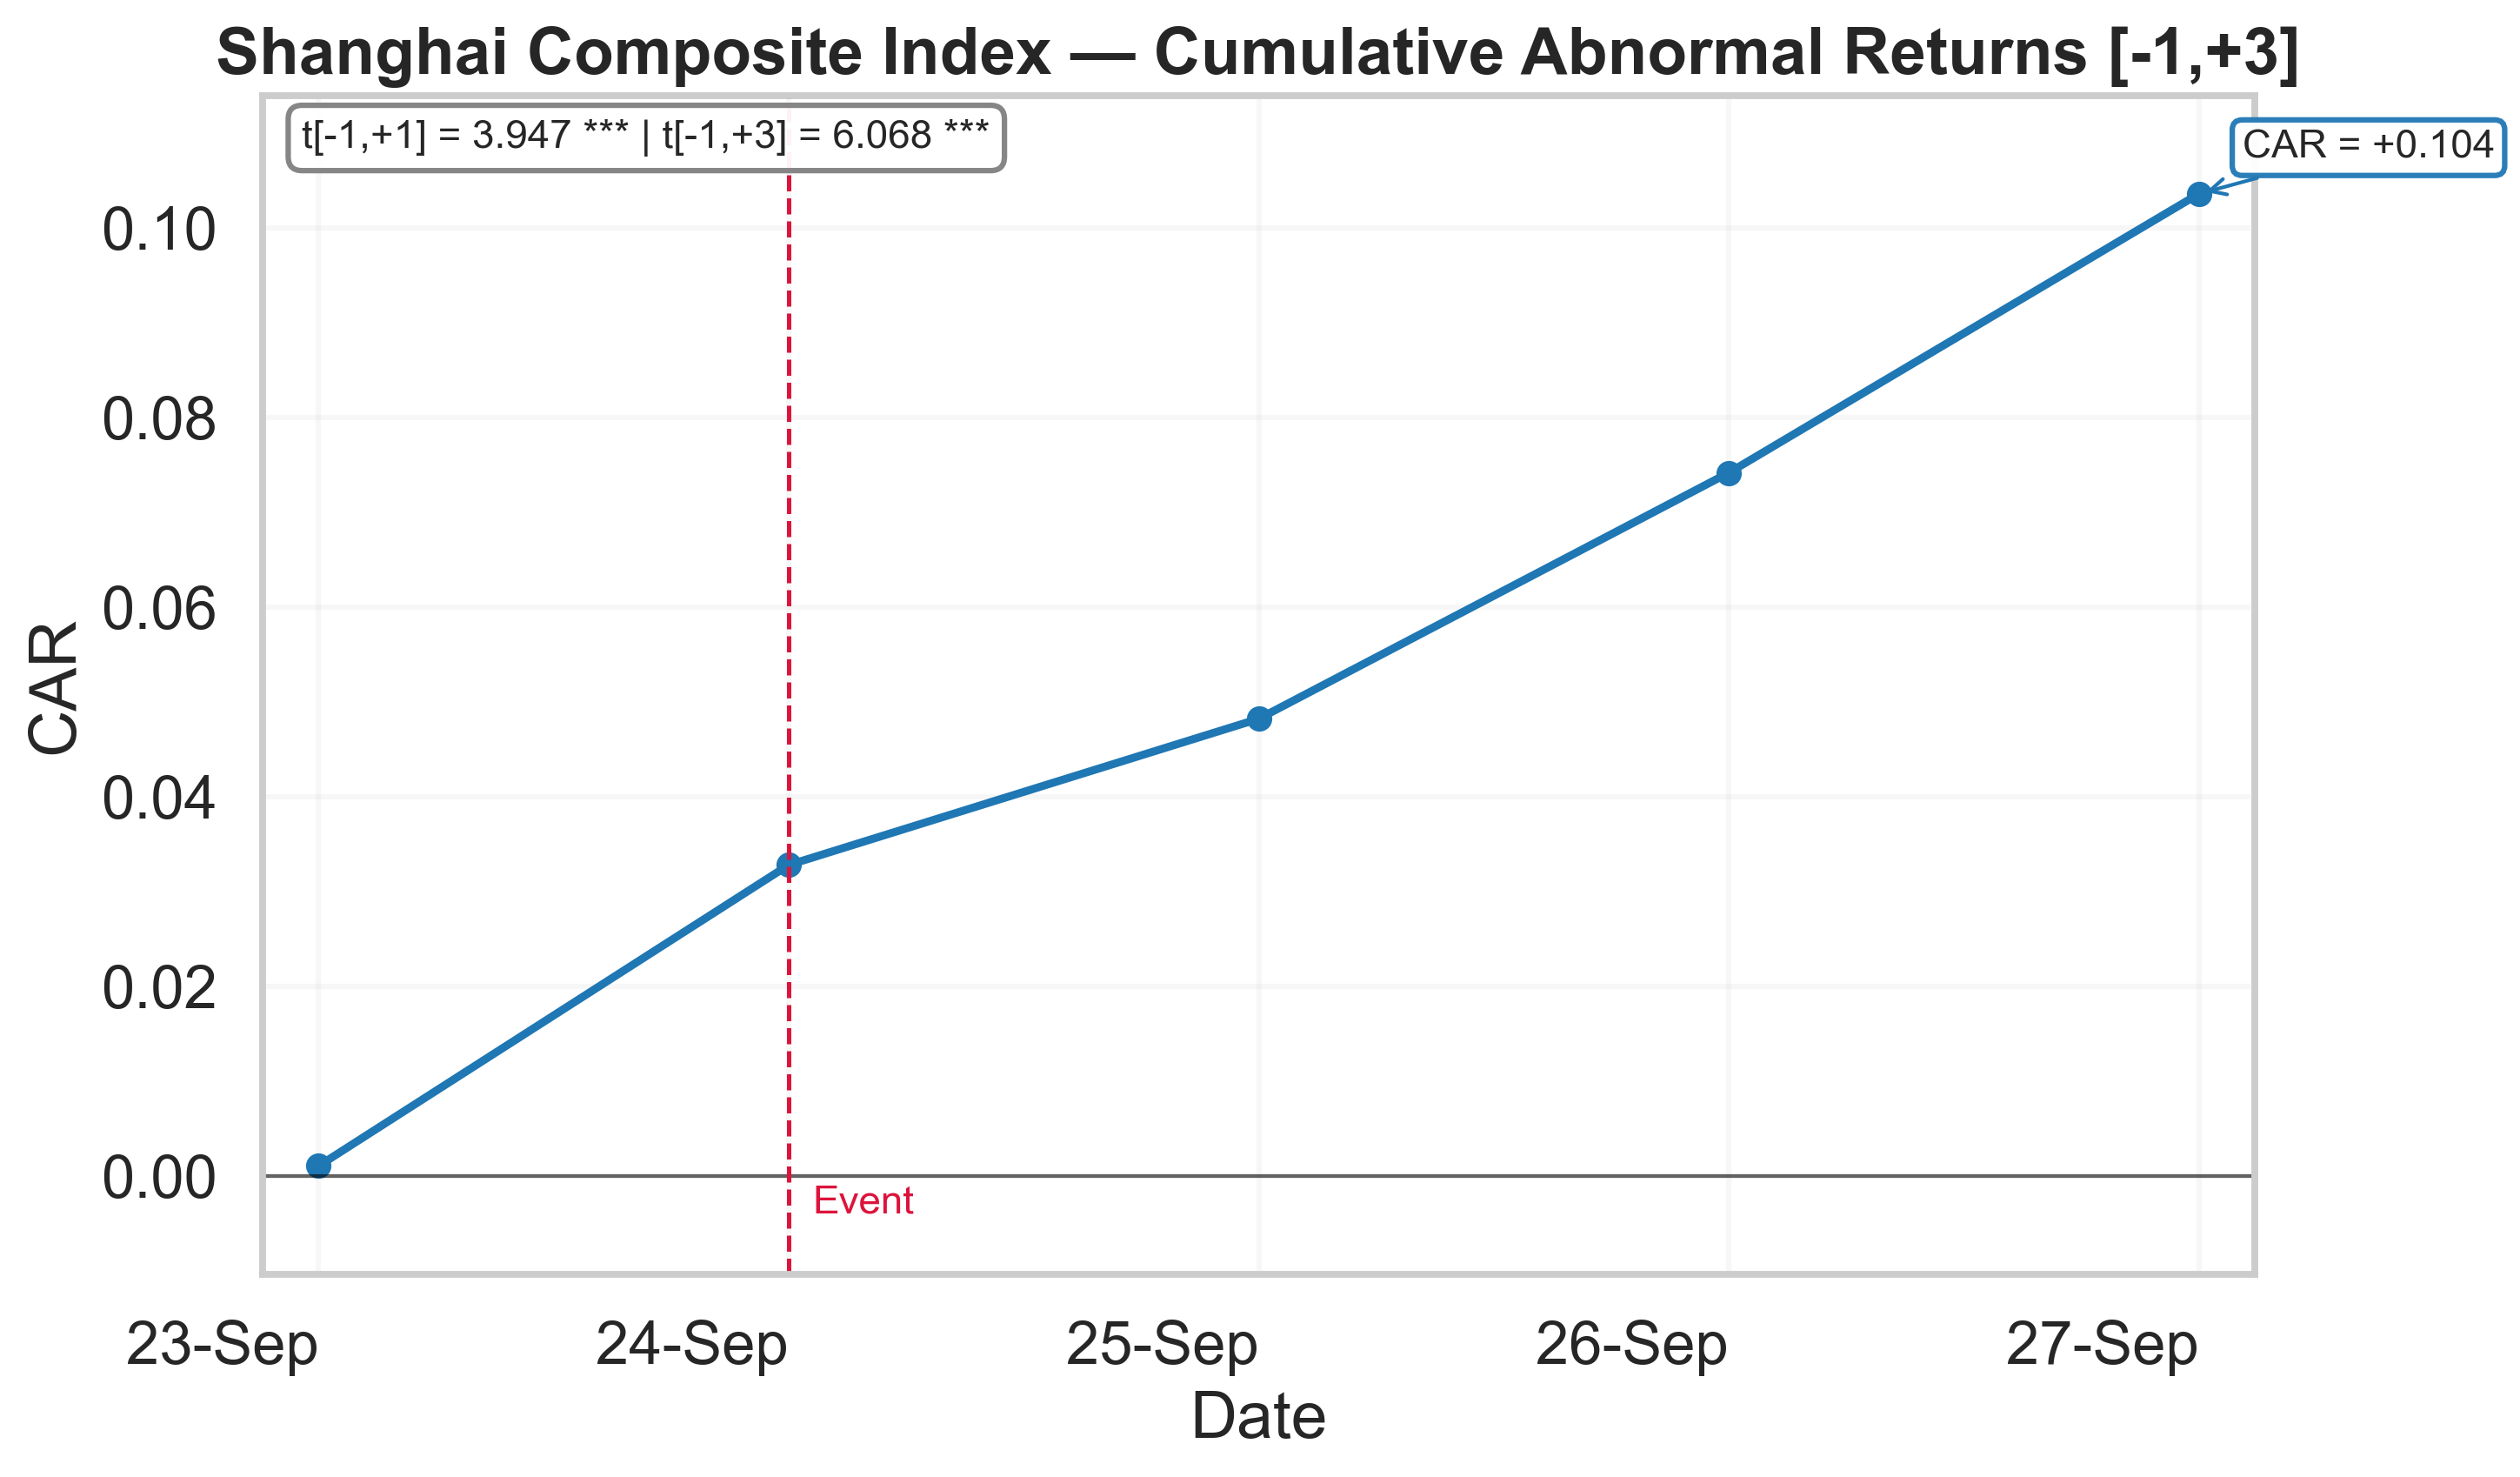

In [63]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import timedelta

sns.set_theme(style="whitegrid", context="talk")

car_s = out_idx['CAR'].copy()
EVENT_DATE = car_s.index[1] if len(car_s) >= 2 else car_s.index[0]   # ← sostituisci con la tua

def _stars(t): 
    return '***' if abs(t) >= 2.58 else '**' if abs(t) >= 1.96 else '*' if abs(t) >= 1.65 else ''

t01 = globals().get('t_CAR_01', None)
t03 = globals().get('t_CAR_03', None)
box_text = " | ".join(
    [f"t[-1,+1] = {t01:.3f} {_stars(t01)}" for _ in [0] if isinstance(t01,(int,float))] +
    [f"t[-1,+3] = {t03:.3f} {_stars(t03)}" for _ in [0] if isinstance(t03,(int,float))]
)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(car_s.index, car_s.values, color='#1f77b4', lw=2.2, marker='o', ms=6)

ax.axhline(0, color='black', lw=1, alpha=.6)
ax.axvline(EVENT_DATE, color='crimson', ls='--', lw=1.2)
ax.text(EVENT_DATE + timedelta(days=0.05), ax.get_ylim()[0]*0.95, "Event", color='crimson', fontsize=11)

ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
fig.autofmt_xdate(rotation=0)   # niente rotazione “brutta”
ax.margins(x=0.03, y=0.10)

ax.set_title("Shanghai Composite Index — Cumulative Abnormal Returns [-1,+3]")
ax.set_xlabel("Date")
ax.set_ylabel("CAR")

if box_text:
    ax.text(0.02, 0.98, box_text, transform=ax.transAxes, va='top', ha='left',
            fontsize=11, bbox=dict(boxstyle="round,pad=0.35", fc="white", ec="grey", alpha=.95))

last_x, last_y = car_s.index[-1], float(car_s.iloc[-1])
ax.annotate(f"CAR = {last_y:+.3f}",
            xy=(last_x, last_y), xytext=(12, 10), textcoords="offset points",
            fontsize=11, bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="#1f77b4", alpha=.95),
            arrowprops=dict(arrowstyle="->", color="#1f77b4", lw=1.0))

plt.tight_layout()
plt.savefig("HP1_SCI_CAR_line_clean.png", dpi=300, bbox_inches='tight')
plt.show()


In [64]:
cols_presenti = [c for c in ['CAR[-1,+3]','t-CAR[-1,+3]','sig'] if c in CAR_sector.columns]
tbl = CAR_sector[cols_presenti].copy()

tbl = tbl.sort_values('CAR[-1,+3]', ascending=False)
tbl.index.name = 'Sector'

fmt = {}
if 'CAR[-1,+3]' in tbl.columns:     fmt['CAR[-1,+3]'] = '{:+.3f}'
if 't-CAR[-1,+3]' in tbl.columns:   fmt['t-CAR[-1,+3]'] = '{:+.3f}'

(
    tbl.style
       .format(fmt)
       .set_caption("Sector CAR [-1,+3]  (benchmark: SCI)")
       .set_table_styles([
           {'selector':'caption', 'props':'caption-side: top; font-weight: bold; font-size: 14px;'},
           {'selector':'th',      'props':'text-align: center;'},
           {'selector':'td',      'props':'padding: 6px 10px;'},
       ])
       .set_properties(subset=['sig'], **{'text-align':'center'})
)


,"CAR[-1,+3]","t-CAR[-1,+3]",sig
Sector,,,
Consumer Staples,+0.142,+6.159,***
Financials,+0.049,+2.771,***
Utilities,+0.011,+0.514,
Real Estate,-0.003,-0.092,
Communication Services,-0.014,-0.592,
Energy,-0.016,-0.453,
Health Care,-0.016,-0.629,
Industrials,-0.027,-2.777,***
Materials,-0.028,-1.644,


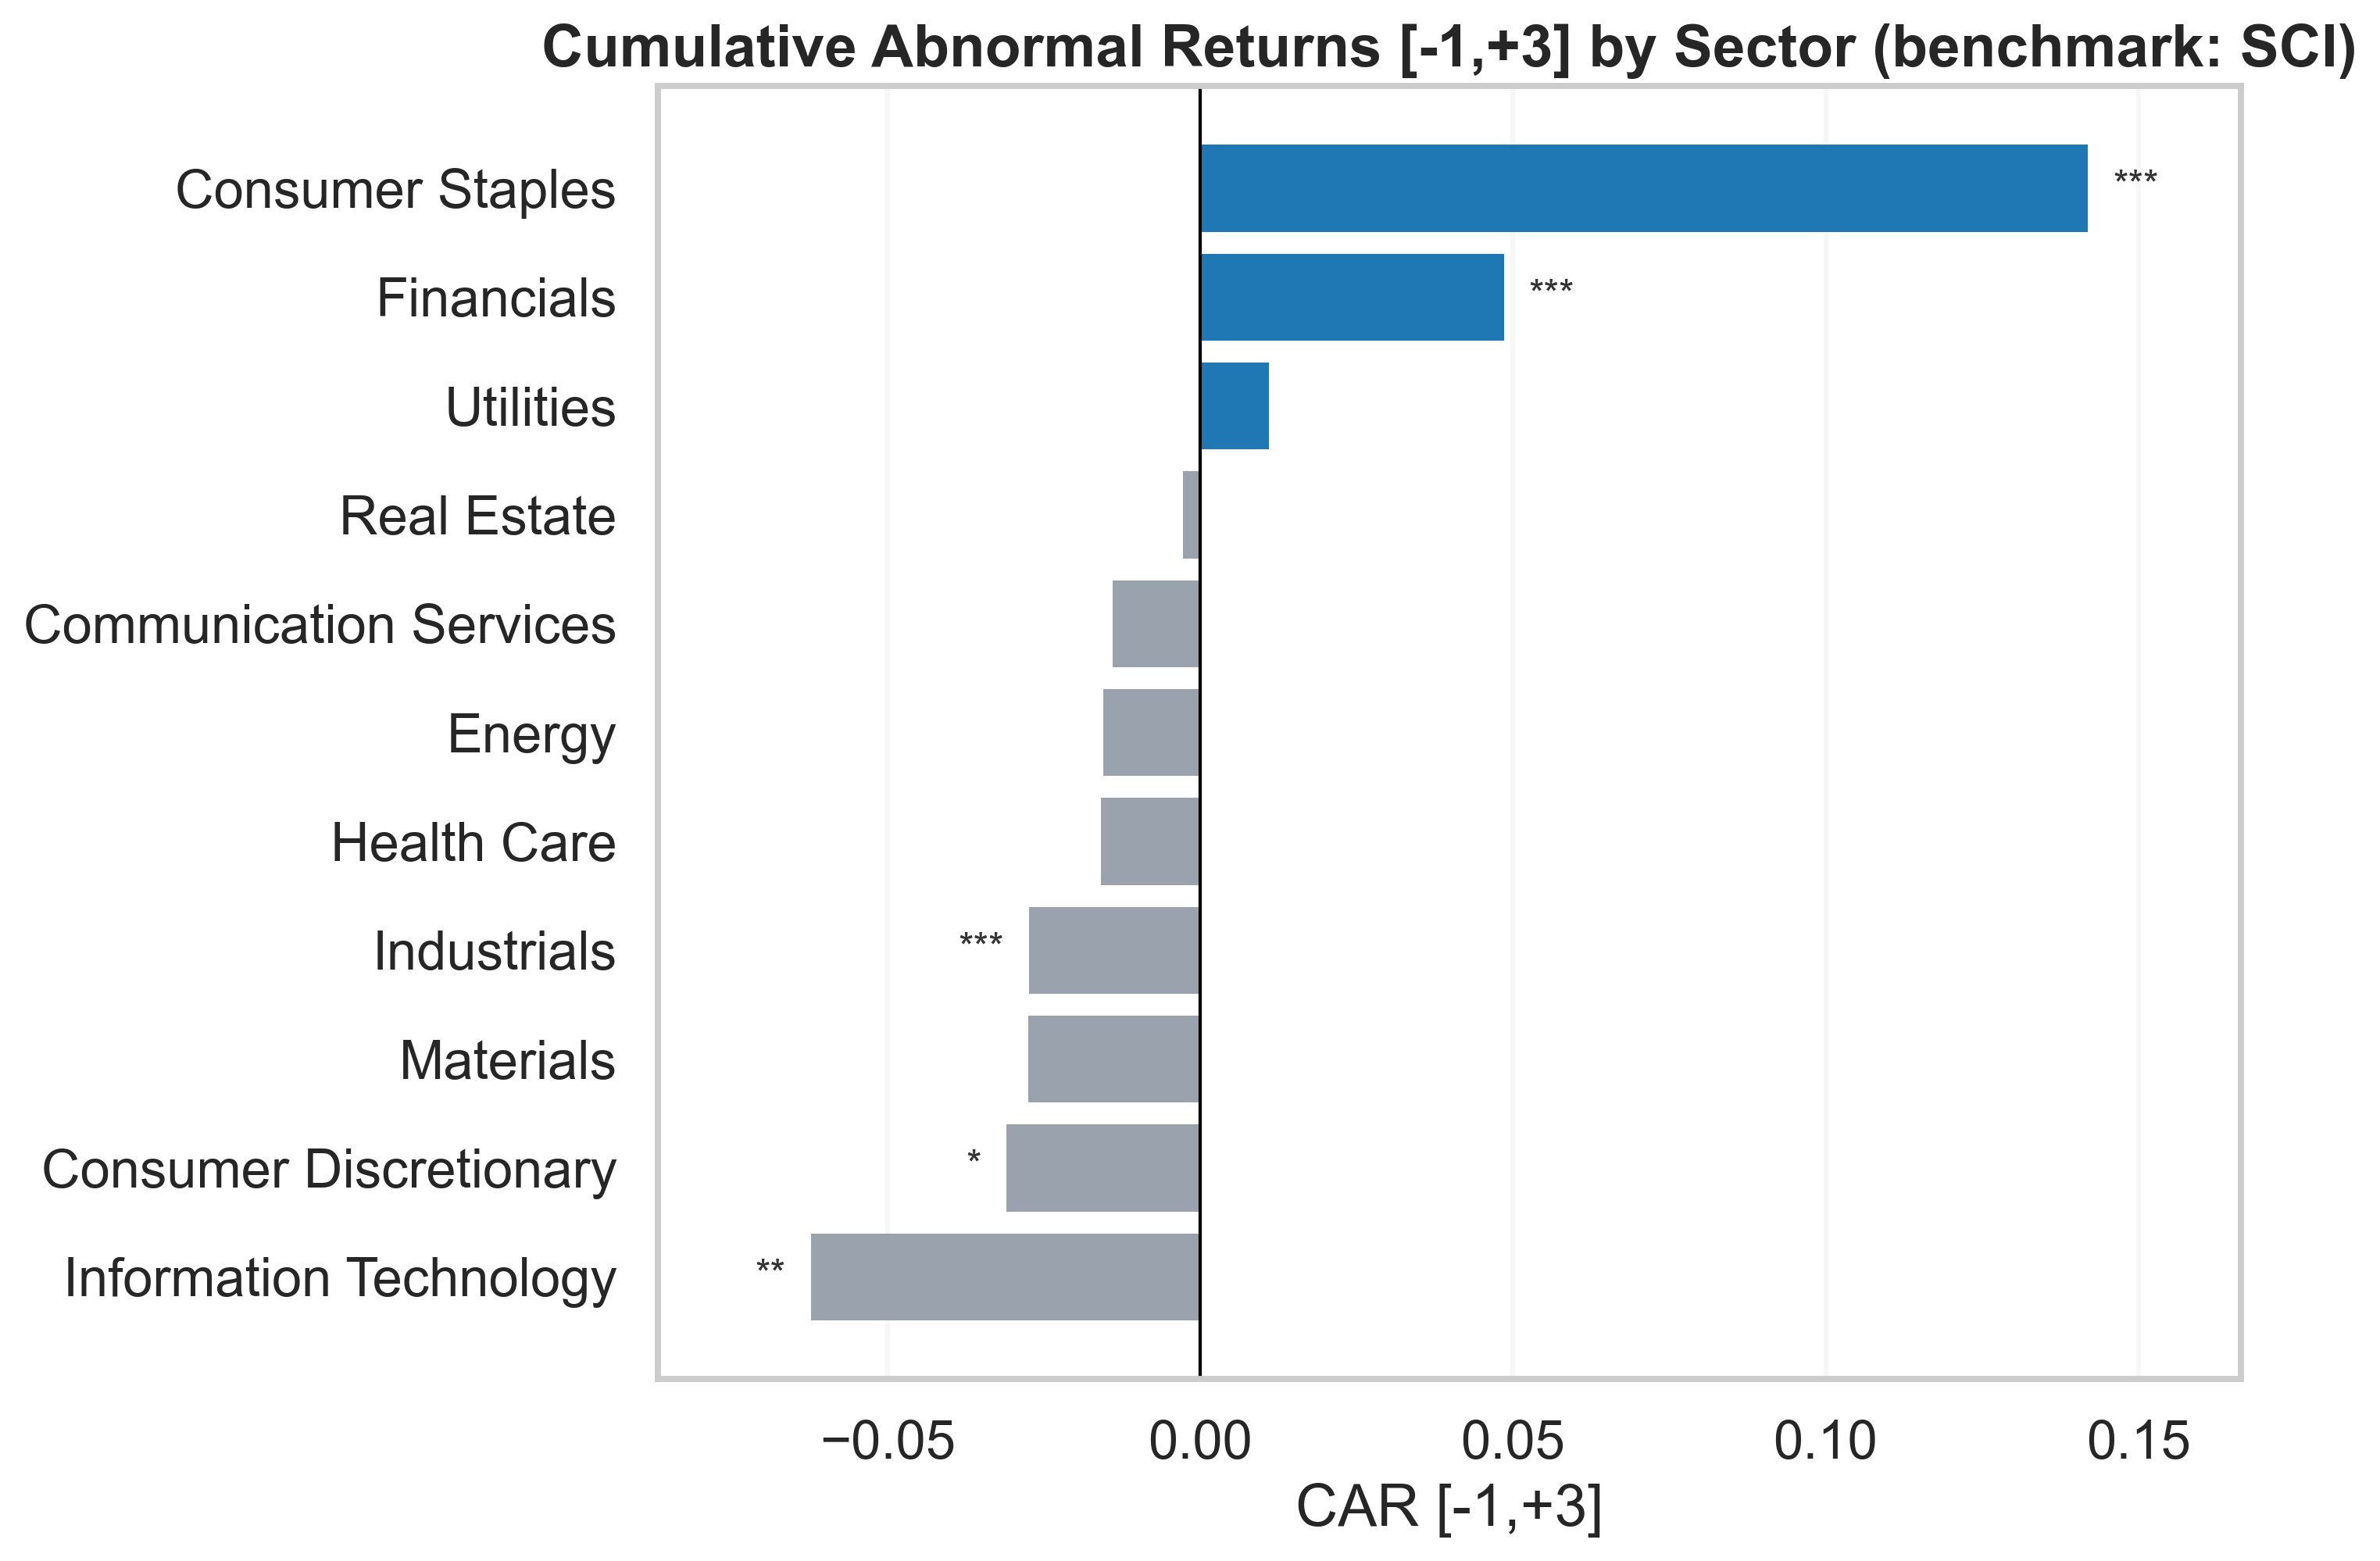

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", context="talk")
dfp = CAR_sector[['CAR[-1,+3]','sig']].copy().sort_values('CAR[-1,+3]', ascending=True)
dfp = dfp.reset_index().rename(columns={'index':'Sector'})

colors = np.where(dfp['CAR[-1,+3]'] >= 0, '#1f77b4', '#9aa3ad')

fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(dfp['Sector'], dfp['CAR[-1,+3]'], color=colors, edgecolor='none')

ax.axvline(0, color='black', lw=1)
ax.xaxis.grid(True, alpha=0.15)
ax.yaxis.grid(False)

pad = 0.004
for y, v, s in zip(range(len(dfp)), dfp['CAR[-1,+3]'], dfp['sig']):
    if isinstance(s, str) and s.strip():
        ax.text(v + (pad if v >= 0 else -pad), y,
                s, va='center', ha='left' if v >= 0 else 'right',
                fontsize=12, color='#333')

ax.set_title("Cumulative Abnormal Returns [-1,+3] by Sector (benchmark: SCI)")
ax.set_xlabel("CAR [-1,+3]")
ax.set_ylabel("")

span = dfp['CAR[-1,+3]'].max() - dfp['CAR[-1,+3]'].min()
ax.set_xlim(dfp['CAR[-1,+3]'].min() - 0.12*span, dfp['CAR[-1,+3]'].max() + 0.12*span)

plt.tight_layout()
plt.savefig("HP1_Sector_CAR_barh_clean.png", dpi=300, bbox_inches='tight')
plt.show()


C:\Users\andre\AppData\Local\Temp\ipykernel_23684\3697273158.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  sector_sync_fmt = sector_sync_fmt[cols].applymap(lambda x: f"{x:.3f}")


,Sector R² (Pre),Sector R² (Post),Δ (Post – Pre)
sector,,,
Consumer Staples,0.174,0.446,0.272
Real Estate,0.299,0.378,0.078
Industrials,0.277,0.365,0.087
Health Care,0.217,0.343,0.126
Consumer Discretionary,0.227,0.321,0.094
Materials,0.278,0.320,0.042
Information Technology,0.283,0.311,0.029
Energy,0.102,0.301,0.198
Financials,0.117,0.296,0.178


C:\Users\andre\AppData\Local\Temp\ipykernel_23684\3697273158.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dfp, y='sector', x='Δ (Post – Pre)', palette='Blues', ax=ax)


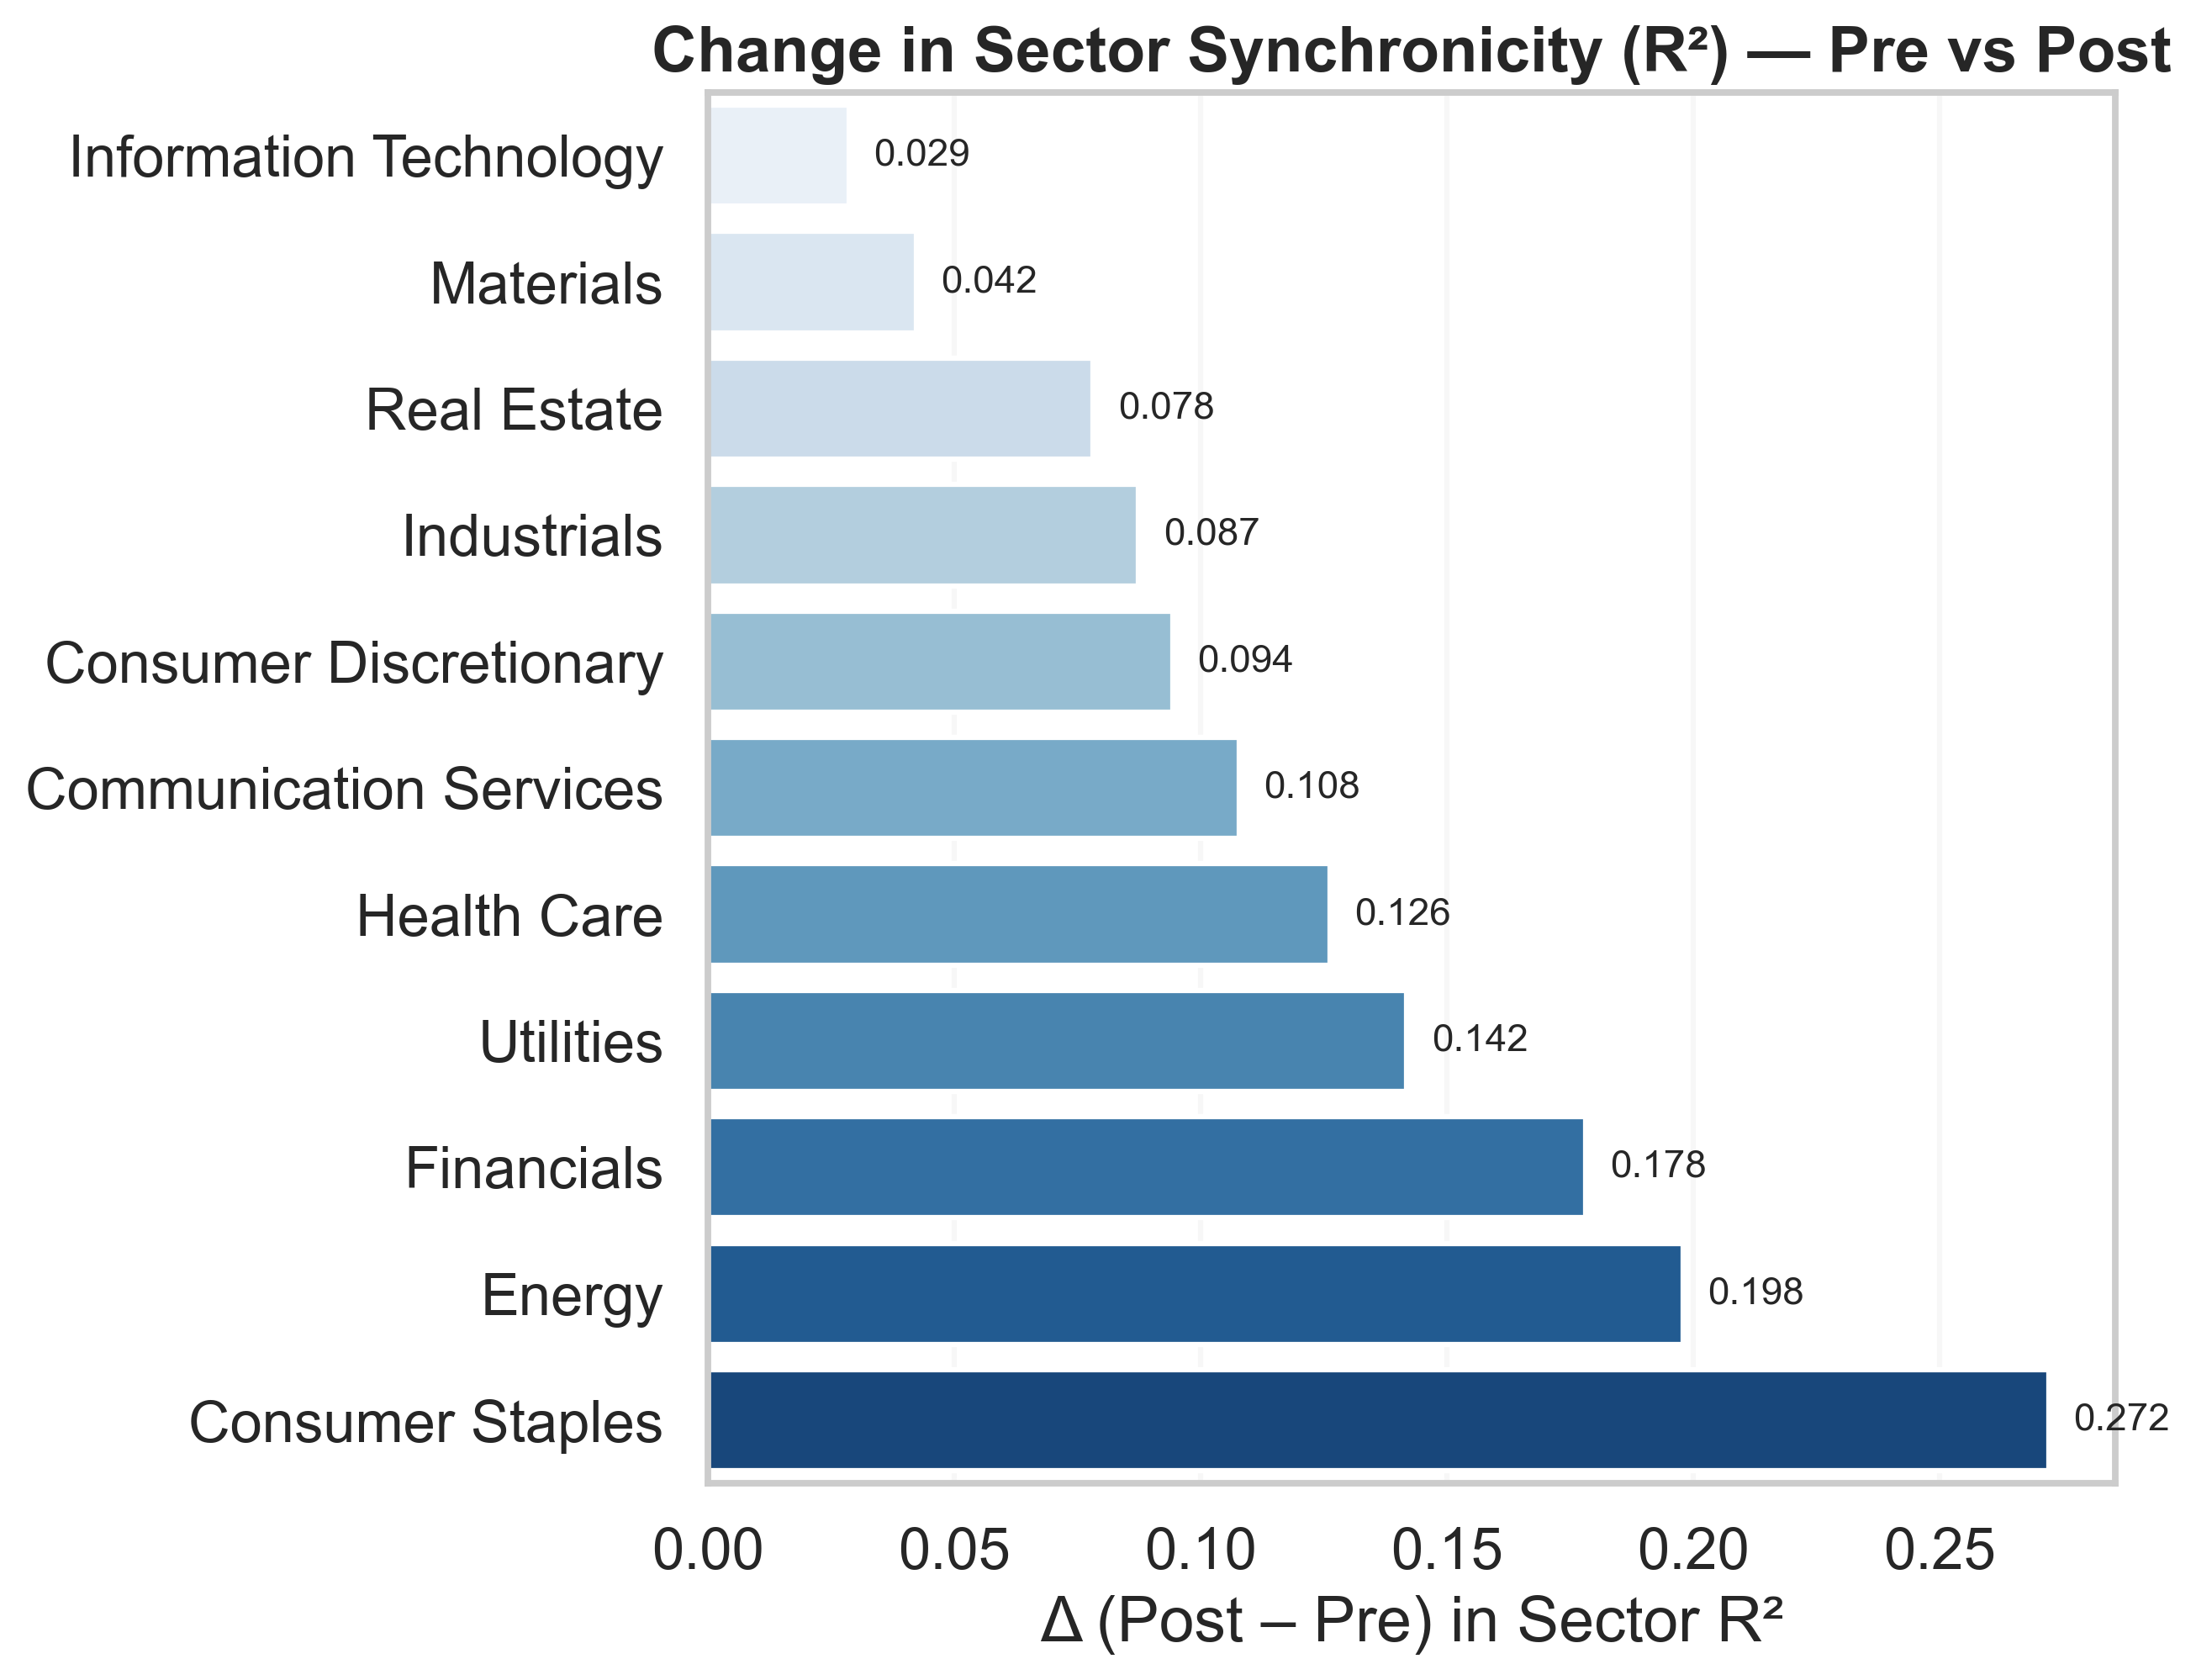

In [66]:
sector_sync_fmt = sector_sync.copy()
cols = ['Sector R² (Pre)', 'Sector R² (Post)', 'Δ (Post – Pre)']
sector_sync_fmt = sector_sync_fmt[cols].applymap(lambda x: f"{x:.3f}")

display(
    sector_sync_fmt.style
    .set_caption("Sector Synchronicity (Value-Weighted R²) — Pre vs Post")
    .set_properties(**{'text-align': 'center'})
    .set_table_styles([
        {'selector':'caption','props':'caption-side:top; font-weight:bold; font-size:14px;'},
        {'selector':'th','props':'text-align:center; font-weight:bold; background-color:#f5f5f5;'},
        {'selector':'td','props':'padding:6px 10px;'},
    ])
)

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid", context="talk")

dfp = sector_sync.sort_values('Δ (Post – Pre)', ascending=True).reset_index()
fig, ax = plt.subplots(figsize=(9,7))
sns.barplot(data=dfp, y='sector', x='Δ (Post – Pre)', palette='Blues', ax=ax)
ax.axvline(0, color='black', lw=1)
ax.set_xlabel("Δ (Post – Pre) in Sector R²")
ax.set_ylabel("")
ax.set_title("Change in Sector Synchronicity (R²) — Pre vs Post")
for i, v in enumerate(dfp['Δ (Post – Pre)']):
    ax.text(v + 0.005 if v >= 0 else v - 0.005, i, f"{v:.3f}", va='center', ha='left' if v >= 0 else 'right', fontsize=11)
plt.tight_layout()
plt.savefig("HP2_sector_synchronicity_clean.png", dpi=300, bbox_inches='tight')
plt.show()


,Amihud (Pre),Amihud (Post),Δ Amihud,N
sector,,,,
Communication Services,216.988141,130.689102,-86.299039,31
Consumer Discretionary,561.094370,306.846448,-254.247922,72
Consumer Staples,262.571629,164.816803,-97.754826,49
Energy,185.864652,134.527062,-51.337591,35
Financials,128.550983,78.450121,-50.100862,79
Health Care,780.621143,415.936457,-364.684686,93
Industrials,622.082946,339.336920,-282.746026,232
Information Technology,730.307544,295.093455,-435.214089,200
Materials,684.951029,358.589008,-326.362021,135


C:\Users\andre\AppData\Local\Temp\ipykernel_23684\2847518080.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=plot_df, y='sector', x='Δ Amihud', order=order, palette='Blues')


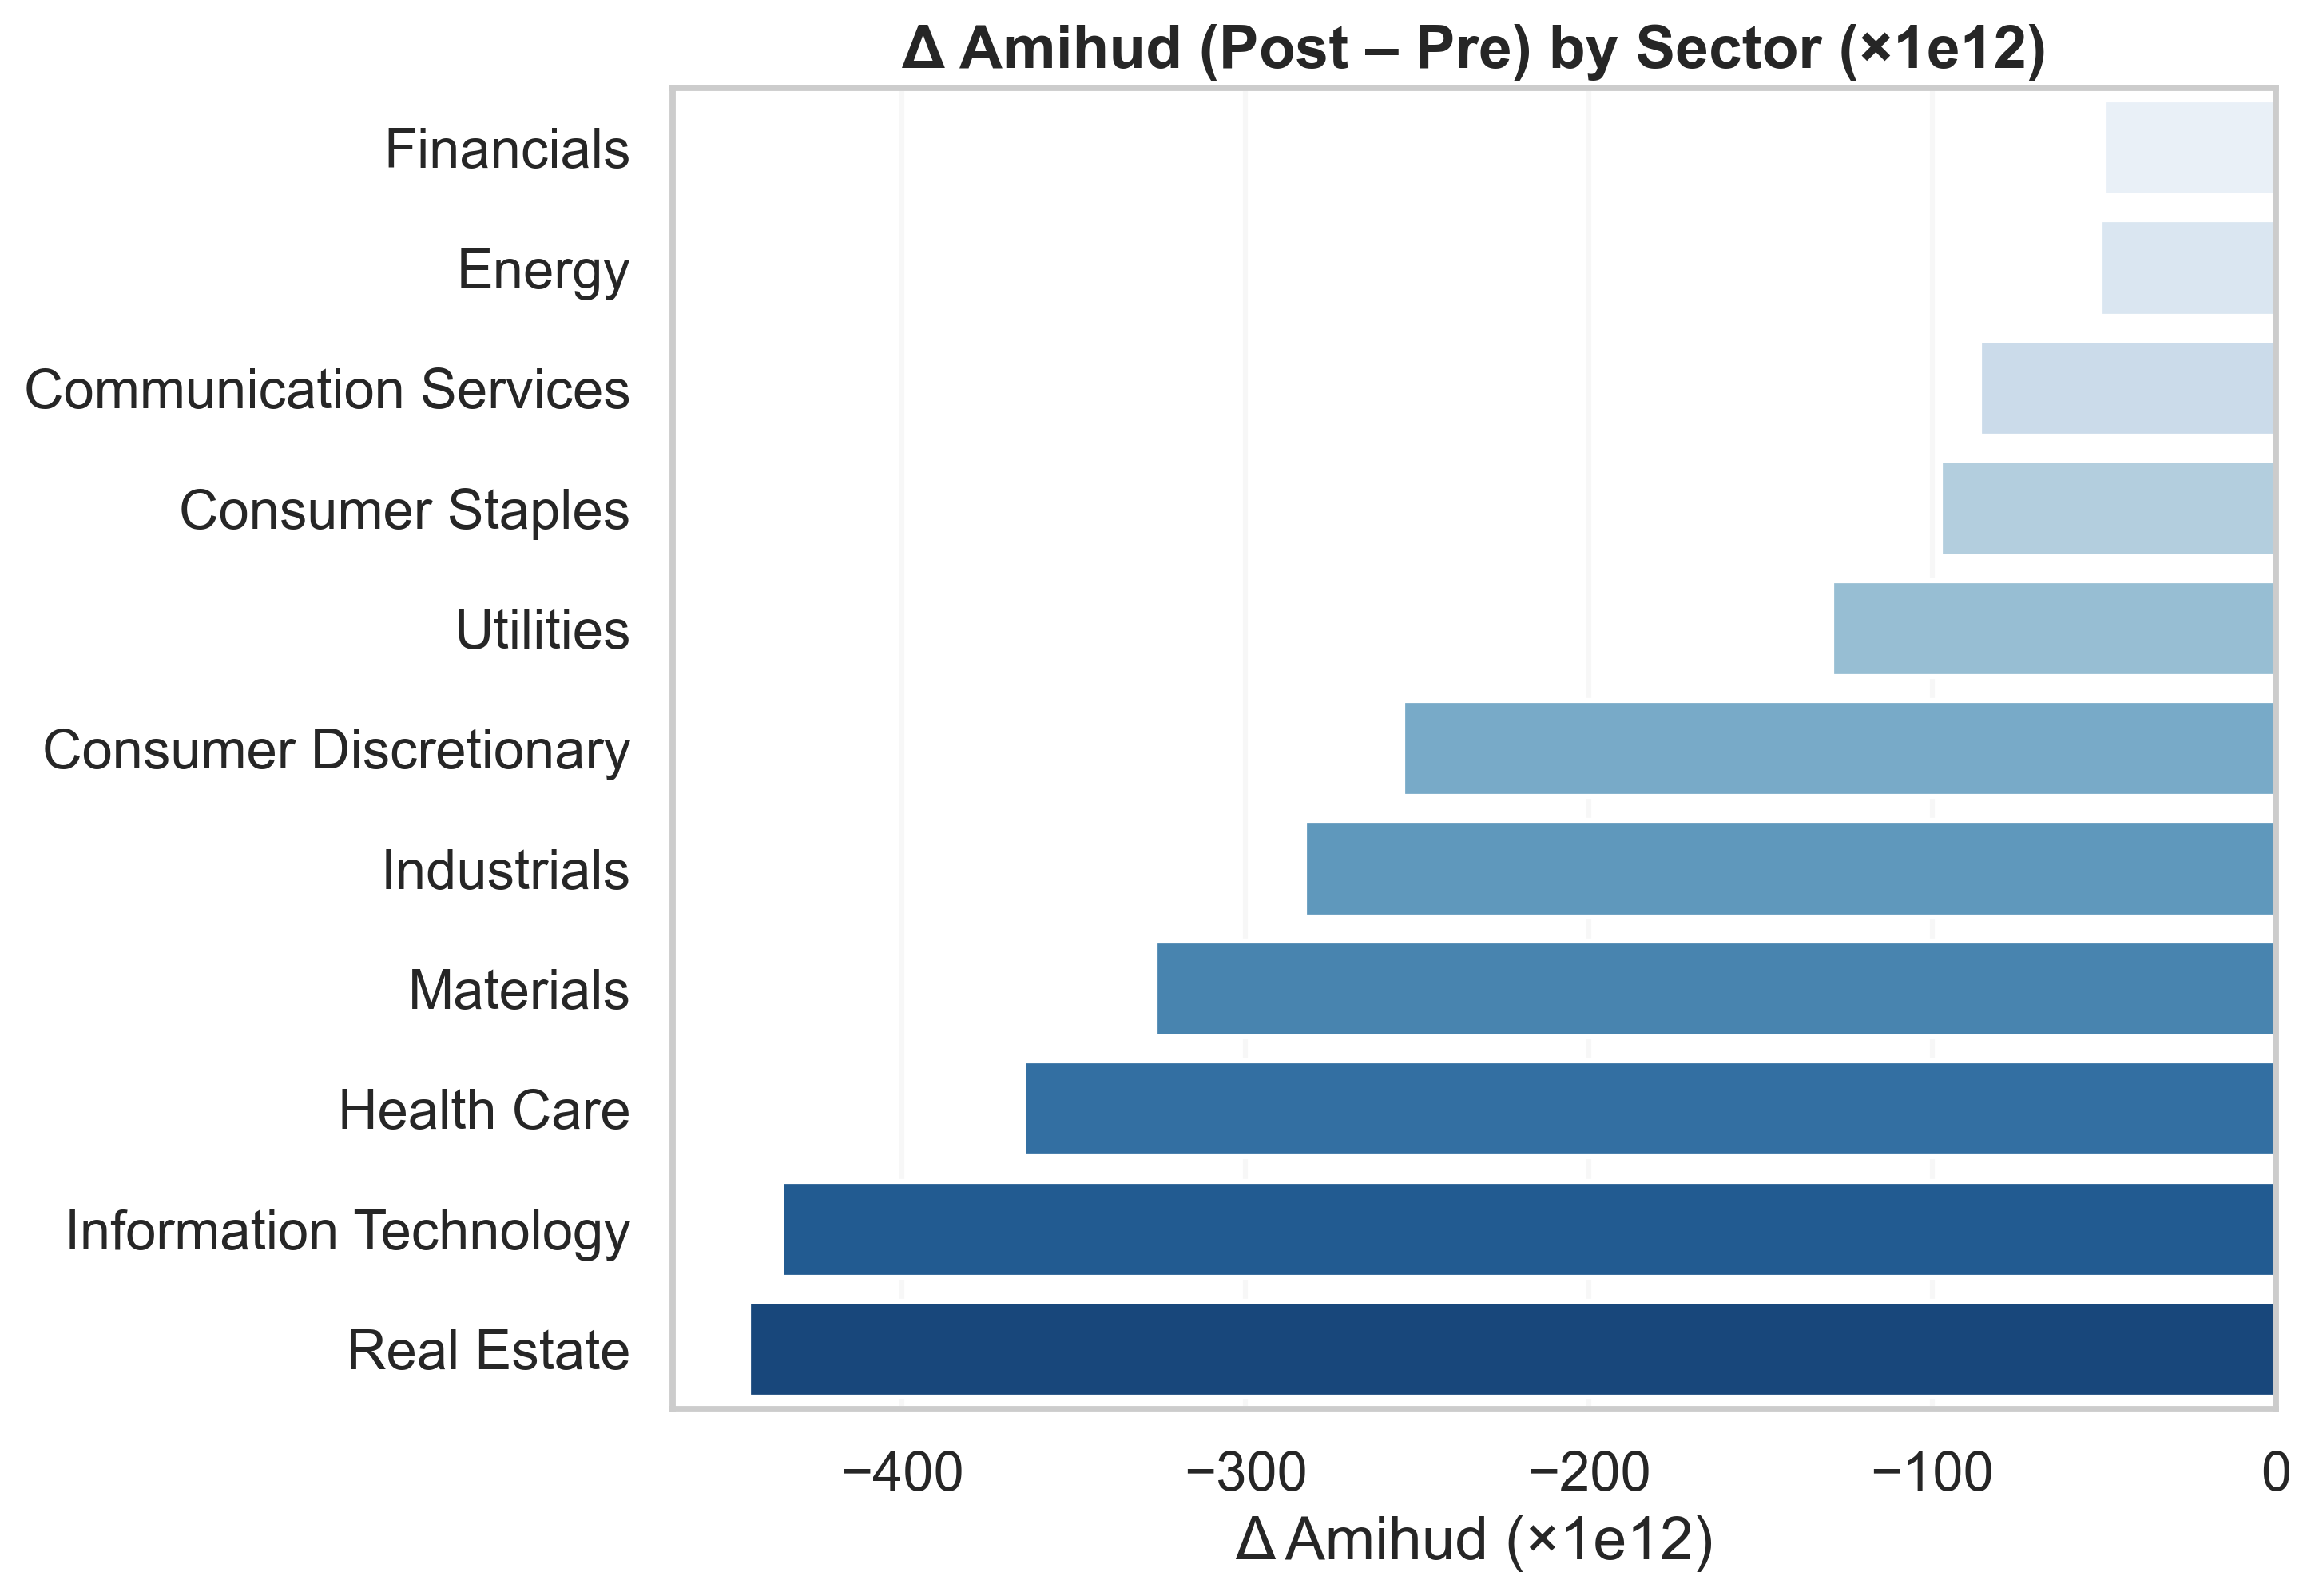

In [67]:
display_cols = ['Amihud (Pre)','Amihud (Post)','Δ Amihud','N']
styled = (amihud_sector_scaled[display_cols]
          .style.format({'Amihud (Pre)':'{:.6f}','Amihud (Post)':'{:.6f}','Δ Amihud':'{:.6f}','N':'{:,.0f}'})
          .background_gradient(subset=['Δ Amihud'], cmap='Blues_r')
          .set_caption(f'Sector Amihud Illiquidity — Pre vs Post{tag}')
         )

display(styled)

amihud_sector_scaled.to_excel('HPx_amihud_sector_table.xlsx')

plot_df = amihud_sector_scaled.reset_index().rename(columns={'index':'sector'})
order = plot_df.sort_values('Δ Amihud', ascending=False)['sector']
plt.figure(figsize=(10,7))
sns.barplot(data=plot_df, y='sector', x='Δ Amihud', order=order, palette='Blues')
plt.axvline(0, color='black', ls='--', lw=0.8)
plt.title(f'Δ Amihud (Post – Pre) by Sector{tag}')
plt.xlabel(f'Δ Amihud{tag}')
plt.ylabel('')
plt.tight_layout()
plt.savefig('HPx_amihud_delta_barplot.png', bbox_inches='tight', dpi=300)
plt.show()

In [68]:
# === Clean, conflict-free version for displaying sector AR table ===

display_cols_ar = [
    'VW β (Pre)', 'VW β (Post)', 'Δ VW β',
    '% Significant (Pre)', '% Significant (Post)', 'Δ % Significant',
    '% Positive β (Pre)', '% Positive β (Post)',
    '% Negative β (Pre)', '% Negative β (Post)',
    'VW R² (Pre)', 'VW R² (Post)', 'Δ VW R²',
    'N (Pre)', 'N (Post)'
]

cols_to_show = [c for c in display_cols_ar if c in out_final.columns]
missing = sorted(set(display_cols_ar) - set(cols_to_show))
if missing:
    print("⚠️  Missing columns:", missing)

sector_table = (
    out_final[cols_to_show]
    .round(3)
    .style
    .set_caption("Sector Autoregression Results — Pre vs Post Rally")
    .set_properties(**{'text-align': 'center', 'font-size': '11pt'})
    .set_table_styles([
        {'selector': 'caption',
         'props': 'caption-side: top; font-weight: bold; font-size: 13pt; text-align: center; color: black;'},
        {'selector': 'th',
         'props': 'background-color: #f2f2f2; color: black; font-weight: bold; text-align: center;'},
        {'selector': 'td',
         'props': 'padding: 6px 10px; text-align: center; border-bottom: 1px solid #ddd;'}
    ])
    .background_gradient(subset=['Δ VW β', 'Δ VW R²'], cmap='Blues', axis=None)
)

display(sector_table)


,VW β (Pre),VW β (Post),Δ VW β,% Significant (Pre),% Significant (Post),Δ % Significant,% Positive β (Pre),% Positive β (Post),% Negative β (Pre),% Negative β (Post),VW R² (Pre),VW R² (Post),Δ VW R²,N (Pre),N (Post)
sector,,,,,,,,,,,,,,,
Energy,-0.096000,-0.090000,0.006000,0.600000,0.571000,-0.029000,0.000000,0.000000,0.600000,0.571000,0.023000,0.013000,-0.010000,35.000000,35.000000
Real Estate,-0.119000,-0.120000,-0.001000,0.407000,0.444000,0.037000,0.037000,0.037000,0.370000,0.407000,0.034000,0.038000,0.005000,27.000000,27.000000
Consumer Staples,-0.056000,-0.081000,-0.025000,0.265000,0.429000,0.163000,0.020000,0.041000,0.245000,0.388000,0.010000,0.016000,0.005000,49.000000,49.000000
Consumer Discretionary,-0.065000,-0.065000,-0.000000,0.431000,0.389000,-0.042000,0.083000,0.056000,0.347000,0.333000,0.029000,0.017000,-0.012000,72.000000,72.000000
Industrials,-0.160000,-0.108000,0.052000,0.483000,0.358000,-0.125000,0.017000,0.017000,0.466000,0.341000,0.049000,0.024000,-0.024000,232.000000,232.000000
Utilities,-0.123000,-0.035000,0.088000,0.489000,0.333000,-0.156000,0.000000,0.044000,0.489000,0.289000,0.023000,0.014000,-0.008000,45.000000,45.000000
Materials,-0.070000,-0.083000,-0.014000,0.400000,0.319000,-0.081000,0.030000,0.007000,0.370000,0.311000,0.025000,0.017000,-0.008000,135.000000,135.000000
Health Care,-0.113000,-0.094000,0.018000,0.333000,0.290000,-0.043000,0.011000,0.032000,0.323000,0.258000,0.030000,0.018000,-0.012000,93.000000,93.000000
Financials,-0.148000,-0.124000,0.024000,0.544000,0.278000,-0.266000,0.013000,0.000000,0.532000,0.278000,0.024000,0.023000,-0.001000,79.000000,79.000000
